In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from blue_conduit_spatial.utilities import build_datasets, load_datasets

In [2]:
# Shape files truncate column names.  This dictionary is used to restore the whole names.

col_name_dictionary = {'pid': 'pid', 'Property Z': 'Property Zip Code', 'Owner Type': 'Owner Type',
                       'Owner Stat': 'Owner State', 'Homestead': 'Homestead', 'Homestea_1': 'Homestead Percent',
                       'HomeSEV': 'HomeSEV', 'Land Value': 'Land Value', 'Land Impro': 'Land Improvements Value',
                       'Residentia': 'Residential Building Value', 'Resident_1': 'Residential Building Style',
                       'Commercial': 'Commercial Building Value', 'Building S': 'Building Storeys',
                       'Parcel Acr': 'Parcel Acres', 'Rental': 'Rental', 'Use Type': 'Use Type',
                       'Prop Class': 'Prop Class', 'Old Prop c': 'Old Prop class', 'Year Built': 'Year Built',
                       'USPS Vacan': 'USPS Vacancy', 'Zoning': 'Zoning', 'Future Lan': 'Future Landuse',
                       'DRAFT Zone': 'DRAFT Zone', 'Housing Co': 'Housing Condition 2012',
                       'Housing _1': 'Housing Condition 2014', 'Commerci_1': 'Commercial Condition 2013',
                       'Latitude': 'Latitude', 'Longitude': 'Longitude', 'Hydrant Ty': 'Hydrant Type',
                       'Ward': 'Ward', 'PRECINCT': 'PRECINCT', 'CENTRACT': 'CENTRACT', 'CENBLOCK': 'CENBLOCK',
                       'SL_Type': 'SL_Type', 'SL_Type2': 'SL_Type2', 'SL_Lead': 'SL_Lead', 'Ed_July': 'Ed_July',
                       'Ed_March': 'Ed_March', 'Last_Test': 'Last_Test', 'Max_Lead': 'Max_Lead',
                       'Med_Lead': 'Med_Lead', 'Num_Tests': 'Num_Tests', 'Res_Test': 'Res_Test',
                       'Sen_Test': 'Sen_Test', 'SL_private': 'SL_private_inspection',
                       'B_median_a': 'B_median_age_all_women', 'B_median_1': 'B_median_age_all_men', 
                       'B_median_2': 'B_median_age_all', 'B_median_3': 'B_median_age_all_women_white',
                       'B_median_4': 'B_median_age_all_men_white', 'B_median_5': 'B_median_age_all_white',
                       'B_median_6': 'B_median_age_all_women_black', 'B_median_7': 'B_median_age_all_men_black',
                       'B_median_8': 'B_median_age_all_black', 'B_total_bl': 'B_total_black_pop',
                       'B_total_wh': 'B_total_white_pop', 'B_married_': 'B_married_couples',
                       'B_single_w': 'B_single_women', 'B_marrie_1': 'B_married_couples_white',
                       'B_single_1': 'B_single_women_white', 'B_marrie_2': 'B_married_couples_black',
                       'B_single_2': 'B_single_women_black', 'B_marrie_3': 'B_married_couples_w_children',
                       'B_single_m': 'B_single_mothers_w_children', 'B_househol': 'B_households_w_elderly',
                       'B_househod': 'B_househod_no_elderly', 'B_aggregat': 'B_aggregate_income',
                       'B_speak_sp': 'B_speak_spanish', 'B_speak_on': 'B_speak_only_english',
                       'B_no_engli': 'B_no_english', 'B_hispanic': 'B_hispanic_household',
                       'B_imputed_': 'B_imputed_rent', 'B_impute_1': 'B_imputed_value',
                       'known_priv': 'known_private_sl', 'known_publ': 'known_public_sl', 'hydrovac': 'hydrovac',
                       'sl_priva_1': 'sl_private_type', 'sl_public_': 'sl_public_type', 'created_at': 'created_at',
                       'source': 'source', 'hv_visit': 'hv_visit', 'sl_visit': 'sl_visit', 'replaced': 'replaced',
                       'dangerous': 'dangerous', 'geometry': 'geometry'}

In [3]:
# Update path to the new shapefile I sent.

sl_df = gpd.read_file('../data/raw/flint_sl_materials/')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

In [4]:
sl_df.shape

(55858, 85)

In [5]:
# Drop columns that aren't used by the classifier

drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry', 
            'Latitude', 'Longitude']

data = sl_df.drop(drop_cols, axis = 1)

# Only keep labelled data
data = data[~pd.isnull(sl_df['Longitude'])]
data = data[~pd.isnull(data.dangerous)].reset_index()

# Drop everything except target from training data
Xdata = data.drop(['pid', 'sl_private_type', 'sl_public_type', 'dangerous'], axis = 1)

# Build target.  Each 'dangerous' is True when sl_private_type OR sl_public_type contain lead.
Ydata = data[['sl_private_type', 'sl_public_type', 'dangerous']]

pid = data.pid


dummy_cols = ['Property Zip Code', 'Owner Type', 'Residential Building Style', 'Homestead', 'Building Storeys',
              'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
              'Housing Condition 2014', 'Owner State', 'Zoning', 'Future Landuse', 'Commercial Condition 2013',
              'Hydrant Type', 'SL_Type', 'SL_Type2', 'DRAFT Zone', 'Last_Test', 'SL_private_inspection', 'Ward',
              'CENTRACT', 'CENBLOCK']#, 'PRECINCT']

# Fill missing data
Xdata = Xdata.fillna(-1)

# Create dummies from categorical columns
Xdata = pd.get_dummies(Xdata, columns=dummy_cols)

# Groups for spatial cross validation
groups = Xdata['PRECINCT']
Xdata = Xdata.drop('PRECINCT', axis=1)

In [6]:
Xdata.head()

index  Homestead Percent  HomeSEV  Land Value  Land Improvements Value  \
0     38              100.0    18400         932                        0   
1     47              100.0    11800         420                        0   
2     53                0.0        0         602                        0   
3     59               50.0     4550         781                        0   
4     70              100.0    12800         510                        0   

   Residential Building Value  Commercial Building Value  Parcel Acres  \
0                       35843                        0.0         0.140   
1                       23227                        0.0         0.050   
2                       18180                        0.0         0.051   
3                       17452                        0.0         0.086   
4                       25104                        0.0         0.070   

   Year Built  SL_Lead  ...  CENTRACT_3800  CENTRACT_4000  CENTRACT_13500  \
0           2        0  ...              0              0               0   
1           2        0  ...              0              0               0   
2        1912        0  ...              0              0               0   
3           2        0  ...              0              0               0   
4        1900        0  ...              0              0               0   

   CENTRACT_13600  CENBLOCK_1  CENBLOCK_2  CENBLOCK_3  CENBLOCK_4  CENBLOCK_5  \
0               0           0           1           0           0           0   
1               0           0           1           0           0           0   
2               0           0           1           0           0           0   
3               0           0           1           0           0           0   
4               0           0           1           0           0           0   

   CENBLOCK_6  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 302 columns]

In [7]:
Xdata.shape

(26857, 302)

2021-10-26 00:36.18 [info     ] New PartitionsBuilder created, using 17.62 MB of memory
[15]


  0%|                                                                                                    | 0/1 [00:00<?, ?it/s]

2021-10-26 00:36.19 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 12467.71it/s]

2021-10-26 00:36.21 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:36.21 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:36.23 [debug    ] Total parcels after join: 26857
2021-10-26 00:36.24 [info     ] Building the connected graph on the partitions.
2021-10-26 00:36.24 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.64 MB of memory
2021-10-26 00:36.24 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:36.24 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:36.24 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


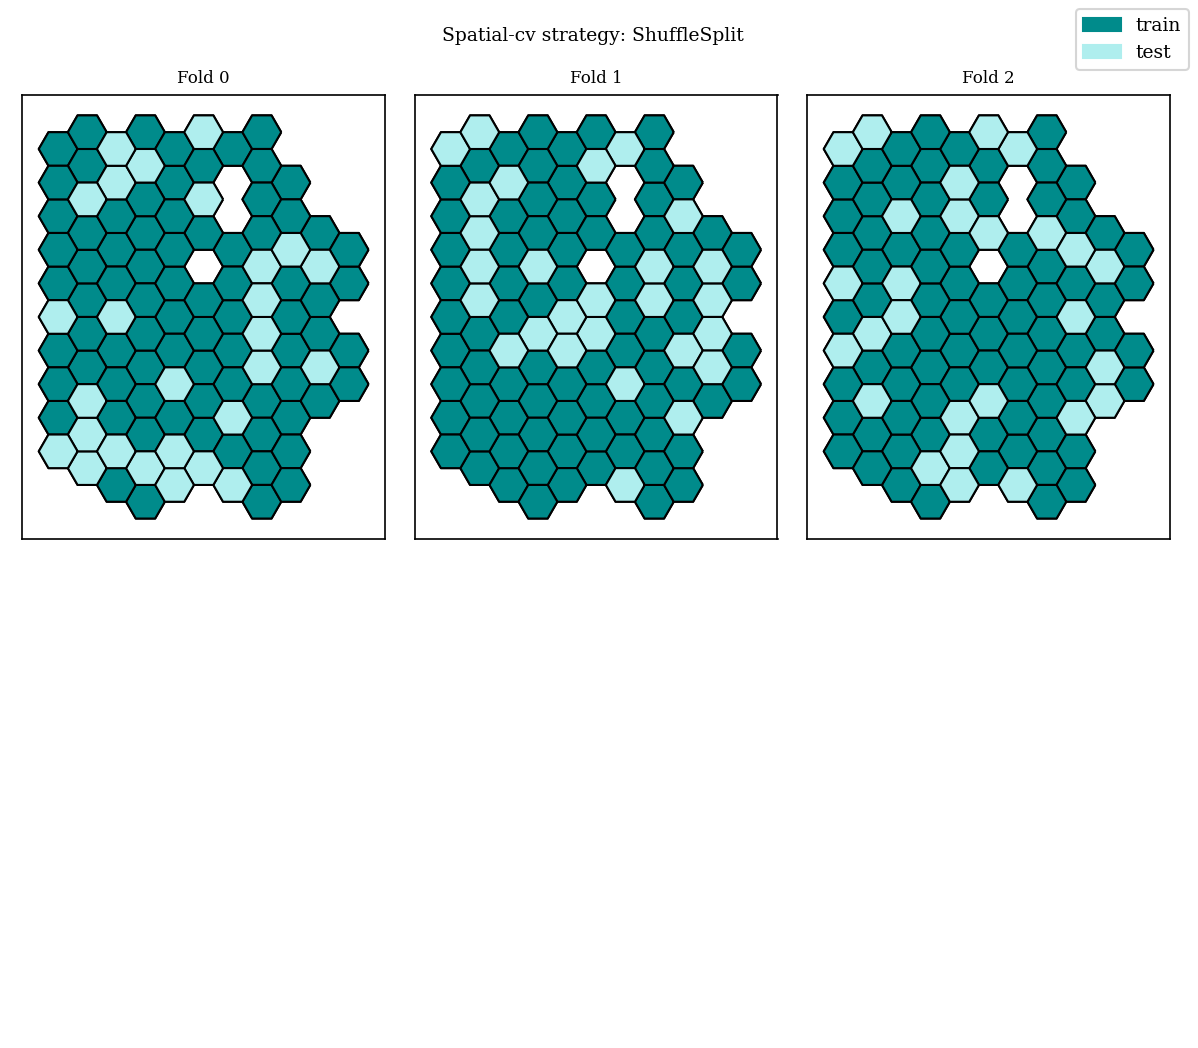

In [26]:
def test_build(Xdata, Ydata, pid):

    data_dir = '../data'
    data_raw_path = f'{data_dir}/raw/flint_sl_materials/'
    save_dir = f'{data_dir}/test_dir'
    Xdata_, Ydata_, pid_, _, _, _ = build_datasets(data_raw_path, save_dir=save_dir)
    
    assert Xdata.drop('index', axis=1).equals(Xdata_)
    assert Ydata.equals(Ydata_)
    assert pid_.pid.astype(pid.dtypes).equals(pid)
    
def test_load(Xdata, Ydata, pid):

    data_dir = '../data'
    save_dir = f'{data_dir}/test_dir'
    
    Xdata = Xdata.drop('index', axis=1).reset_index(drop=True)
    Ydata = Ydata.reset_index(drop=True)
    Ydata['dangerous'] = Ydata['dangerous'].astype(int)
    
    Xdata_, Ydata_, pid_, _, _, _ = load_datasets(save_dir)
    
    assert Xdata_.astype(Xdata.dtypes).equals(Xdata)
    assert Ydata_.astype(Ydata.dtypes).equals(Ydata)
    assert pid_['pid'].equals(pid)
    
def test_index():
    
    data_dir = '../data'
    save_dir = f'{data_dir}/processed'
    Xdata, Ydata, pid, train_idx_, test_idx_, partitions_builder = load_datasets(save_dir)
    
#     N = Xdata_.shape[0]
    N = None
    
    train_size_list = list(train_idx_.keys())
    train_size_0 = train_size_list[0]
    cells_across_list = list(train_idx_[train_size_0].keys())

    for train_size_ in train_size_list:
        for num_cells_across in cells_across_list:
            train_size_float = float(train_size_.lstrip('ts_'))
            for train_split, test_split in zip(train_idx_[train_size_], test_idx_[train_size_]):
                N_train_split = len(train_split)
                N_test_split = len(test_split)

                # Train and test split sum up to the full dataset size
                if N is None:
                    N = N_train_split + N_test_split
                assert N_train_split+N_test_split==N

                # Less than 5% of missmatch between expected split train size and actual split train size
                diff = np.abs(N_train_split-N*train_size_float)/N
                assert diff<0.5
    
test_build(Xdata, Ydata, pid)
test_load(Xdata, Ydata, pid)
test_index()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
2021-10-26 00:39.01 [info     ] New PartitionsBuilder created, using 17.62 MB of memory
[ 5 10 22 47 99]


  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

2021-10-26 00:39.03 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 11324.83it/s]

2021-10-26 00:39.04 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:39.04 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:39.06 [debug    ] Total parcels after join: 26857
2021-10-26 00:39.07 [info     ] Building the connected graph on the partitions.
2021-10-26 00:39.07 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-10-26 00:39.07 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:39.07 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:39.07 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|██████████████████▍                                                                         | 1/5 [00:05<00:23,  5.78s/it]

2021-10-26 00:39.08 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 14248.72it/s]

2021-10-26 00:39.10 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:39.10 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:39.12 [debug    ] Total parcels after join: 26857
2021-10-26 00:39.13 [info     ] Building the connected graph on the partitions.
2021-10-26 00:39.13 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-10-26 00:39.13 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:39.13 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:39.13 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|████████████████████████████████████▊                                                       | 2/5 [00:11<00:17,  5.91s/it]

2021-10-26 00:39.14 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 13759.31it/s]

2021-10-26 00:39.16 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:39.16 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:39.18 [debug    ] Total parcels after join: 26857
2021-10-26 00:39.19 [info     ] Building the connected graph on the partitions.
2021-10-26 00:39.19 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-10-26 00:39.19 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:39.20 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:39.20 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:18<00:12,  6.22s/it]

2021-10-26 00:39.21 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 19940.50it/s]

2021-10-26 00:39.23 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:39.23 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:39.25 [debug    ] Total parcels after join: 26857
2021-10-26 00:39.26 [info     ] Building the connected graph on the partitions.
2021-10-26 00:39.28 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-10-26 00:39.28 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:39.28 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:39.29 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:27<00:07,  7.51s/it]

2021-10-26 00:39.30 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                                                                 | 0/4828 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:00<00:00, 26401.14it/s]


2021-10-26 00:39.33 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:39.33 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:39.35 [debug    ] Total parcels after join: 26857
2021-10-26 00:39.35 [info     ] Building the connected graph on the partitions.
2021-10-26 00:39.53 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-10-26 00:39.53 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:39.53 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:39.56 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

2021-10-26 00:39.57 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 6862.27it/s]

2021-10-26 00:39.59 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:39.59 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:40.01 [debug    ] Total parcels after join: 26857
2021-10-26 00:40.02 [info     ] Building the connected graph on the partitions.
2021-10-26 00:40.02 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-10-26 00:40.02 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:40.02 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:40.02 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|██████████████████▍                                                                         | 1/5 [00:05<00:22,  5.66s/it]

2021-10-26 00:40.03 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 10483.04it/s]

2021-10-26 00:40.05 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:40.05 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:40.07 [debug    ] Total parcels after join: 26857
2021-10-26 00:40.07 [info     ] Building the connected graph on the partitions.
2021-10-26 00:40.07 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-10-26 00:40.07 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:40.08 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:40.08 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|████████████████████████████████████▊                                                       | 2/5 [00:11<00:17,  5.74s/it]

2021-10-26 00:40.09 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 16608.03it/s]

2021-10-26 00:40.11 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:40.11 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:40.13 [debug    ] Total parcels after join: 26857
2021-10-26 00:40.13 [info     ] Building the connected graph on the partitions.
2021-10-26 00:40.14 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-10-26 00:40.14 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:40.14 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:40.14 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:17<00:12,  6.04s/it]

2021-10-26 00:40.15 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 22309.81it/s]

2021-10-26 00:40.17 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:40.17 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:40.19 [debug    ] Total parcels after join: 26857
2021-10-26 00:40.20 [info     ] Building the connected graph on the partitions.
2021-10-26 00:40.22 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-10-26 00:40.22 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:40.22 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:40.24 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:27<00:07,  7.34s/it]

2021-10-26 00:40.25 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                                                                 | 0/4828 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:00<00:00, 26471.90it/s]


2021-10-26 00:40.27 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:40.27 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:40.29 [debug    ] Total parcels after join: 26857
2021-10-26 00:40.30 [info     ] Building the connected graph on the partitions.
2021-10-26 00:40.47 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-10-26 00:40.47 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:40.47 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:40.50 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

2021-10-26 00:40.51 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 9859.81it/s]

2021-10-26 00:40.53 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:40.53 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:40.55 [debug    ] Total parcels after join: 26857
2021-10-26 00:40.56 [info     ] Building the connected graph on the partitions.
2021-10-26 00:40.56 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-10-26 00:40.56 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:40.56 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:40.56 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|██████████████████▍                                                                         | 1/5 [00:05<00:23,  5.83s/it]

2021-10-26 00:40.57 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 6829.24it/s]

2021-10-26 00:40.59 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:40.59 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:41.01 [debug    ] Total parcels after join: 26857
2021-10-26 00:41.02 [info     ] Building the connected graph on the partitions.
2021-10-26 00:41.02 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-10-26 00:41.02 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:41.02 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:41.02 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|████████████████████████████████████▊                                                       | 2/5 [00:12<00:18,  6.07s/it]

2021-10-26 00:41.03 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 16292.61it/s]

2021-10-26 00:41.05 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:41.05 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:41.07 [debug    ] Total parcels after join: 26857
2021-10-26 00:41.08 [info     ] Building the connected graph on the partitions.
2021-10-26 00:41.08 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-10-26 00:41.08 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:41.09 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:41.09 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:18<00:12,  6.37s/it]

2021-10-26 00:41.10 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 22386.62it/s]

2021-10-26 00:41.12 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:41.12 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:41.14 [debug    ] Total parcels after join: 26857
2021-10-26 00:41.15 [info     ] Building the connected graph on the partitions.
2021-10-26 00:41.17 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-10-26 00:41.17 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:41.18 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:41.19 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:28<00:07,  7.62s/it]

2021-10-26 00:41.20 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                                                                 | 0/4828 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:00<00:00, 25212.66it/s]


2021-10-26 00:41.22 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:41.22 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:41.25 [debug    ] Total parcels after join: 26857
2021-10-26 00:41.25 [info     ] Building the connected graph on the partitions.
2021-10-26 00:41.43 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-10-26 00:41.43 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:41.44 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:41.47 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

2021-10-26 00:41.48 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 6982.40it/s]

2021-10-26 00:41.50 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:41.50 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:41.52 [debug    ] Total parcels after join: 26857
2021-10-26 00:41.52 [info     ] Building the connected graph on the partitions.
2021-10-26 00:41.52 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-10-26 00:41.52 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:41.52 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:41.53 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|██████████████████▍                                                                         | 1/5 [00:05<00:23,  5.99s/it]

2021-10-26 00:41.54 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 9762.75it/s]

2021-10-26 00:41.56 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:41.56 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:41.58 [debug    ] Total parcels after join: 26857
2021-10-26 00:41.58 [info     ] Building the connected graph on the partitions.
2021-10-26 00:41.58 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-10-26 00:41.58 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:41.59 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:41.59 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|████████████████████████████████████▊                                                       | 2/5 [00:12<00:18,  6.12s/it]

2021-10-26 00:42.00 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 15387.15it/s]

2021-10-26 00:42.02 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:42.02 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:42.04 [debug    ] Total parcels after join: 26857
2021-10-26 00:42.04 [info     ] Building the connected graph on the partitions.
2021-10-26 00:42.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-10-26 00:42.05 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:42.05 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:42.06 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:18<00:12,  6.40s/it]

2021-10-26 00:42.07 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 19853.50it/s]

2021-10-26 00:42.09 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:42.09 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:42.11 [debug    ] Total parcels after join: 26857
2021-10-26 00:42.11 [info     ] Building the connected graph on the partitions.
2021-10-26 00:42.14 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-10-26 00:42.14 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:42.14 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:42.15 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:28<00:07,  7.66s/it]

2021-10-26 00:42.16 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                                                                 | 0/4828 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:00<00:00, 25617.21it/s]


2021-10-26 00:42.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:42.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:42.21 [debug    ] Total parcels after join: 26857
2021-10-26 00:42.21 [info     ] Building the connected graph on the partitions.
2021-10-26 00:42.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-10-26 00:42.42 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:42.43 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:42.45 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

2021-10-26 00:42.46 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 7739.43it/s]

2021-10-26 00:42.49 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:42.49 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:42.52 [debug    ] Total parcels after join: 26857
2021-10-26 00:42.52 [info     ] Building the connected graph on the partitions.
2021-10-26 00:42.52 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-10-26 00:42.52 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:42.52 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:549: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  dpi=150,


2021-10-26 00:42.52 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|██████████████████▍                                                                         | 1/5 [00:06<00:27,  6.91s/it]

2021-10-26 00:42.53 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 14355.12it/s]

2021-10-26 00:42.55 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:42.55 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:42.57 [debug    ] Total parcels after join: 26857
2021-10-26 00:42.58 [info     ] Building the connected graph on the partitions.
2021-10-26 00:42.58 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-10-26 00:42.58 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:42.58 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:42.58 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|████████████████████████████████████▊                                                       | 2/5 [00:12<00:19,  6.40s/it]

2021-10-26 00:42.59 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 14124.54it/s]

2021-10-26 00:43.01 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:43.01 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:43.03 [debug    ] Total parcels after join: 26857
2021-10-26 00:43.04 [info     ] Building the connected graph on the partitions.
2021-10-26 00:43.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-10-26 00:43.05 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:43.05 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:43.05 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:19<00:13,  6.58s/it]

2021-10-26 00:43.06 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 23170.25it/s]

2021-10-26 00:43.08 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:43.08 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:43.11 [debug    ] Total parcels after join: 26857
2021-10-26 00:43.11 [info     ] Building the connected graph on the partitions.
2021-10-26 00:43.14 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-10-26 00:43.14 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:43.14 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:43.15 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:29<00:07,  7.86s/it]

2021-10-26 00:43.16 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                                                                 | 0/4828 [00:00<?, ?it/s]

 49%|████████████████████████████████████████▊                                          | 2376/4828 [00:00<00:00, 23758.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:00<00:00, 22193.20it/s]

2021-10-26 00:43.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:43.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:43.21 [debug    ] Total parcels after join: 26857
2021-10-26 00:43.22 [info     ] Building the connected graph on the partitions.
2021-10-26 00:43.40 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-10-26 00:43.40 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:43.40 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:43.43 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

2021-10-26 00:43.44 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 6279.75it/s]

2021-10-26 00:43.46 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:43.46 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:43.48 [debug    ] Total parcels after join: 26857
2021-10-26 00:43.49 [info     ] Building the connected graph on the partitions.
2021-10-26 00:43.49 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-10-26 00:43.49 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:43.49 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:43.49 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|██████████████████▍                                                                         | 1/5 [00:05<00:23,  5.81s/it]

2021-10-26 00:43.50 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 9183.13it/s]

2021-10-26 00:43.52 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:43.52 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:43.54 [debug    ] Total parcels after join: 26857
2021-10-26 00:43.54 [info     ] Building the connected graph on the partitions.
2021-10-26 00:43.55 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-10-26 00:43.55 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:43.55 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:43.55 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|████████████████████████████████████▊                                                       | 2/5 [00:12<00:18,  6.07s/it]

2021-10-26 00:43.56 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 16462.77it/s]

2021-10-26 00:43.58 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:43.58 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:44.00 [debug    ] Total parcels after join: 26857
2021-10-26 00:44.01 [info     ] Building the connected graph on the partitions.
2021-10-26 00:44.01 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-10-26 00:44.01 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:44.01 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:44.02 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:18<00:12,  6.34s/it]

2021-10-26 00:44.03 [info     ] Generating the partition map of type 'hexagon'




100%|███████████████████████████████████████████████████████████████████████████████████| 1138/1138 [00:00<00:00, 20620.80it/s]

2021-10-26 00:44.05 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:44.05 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:44.07 [debug    ] Total parcels after join: 26857
2021-10-26 00:44.08 [info     ] Building the connected graph on the partitions.
2021-10-26 00:44.10 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-10-26 00:44.10 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:44.10 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:44.11 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:28<00:07,  7.64s/it]

2021-10-26 00:44.12 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                                                                 | 0/4828 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:00<00:00, 24052.57it/s]

2021-10-26 00:44.15 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 00:44.15 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 00:44.17 [debug    ] Total parcels after join: 26857
2021-10-26 00:44.18 [info     ] Building the connected graph on the partitions.
2021-10-26 00:44.36 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-10-26 00:44.36 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 00:44.36 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-26 00:44.39 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:37<00:00, 56.26s/it]


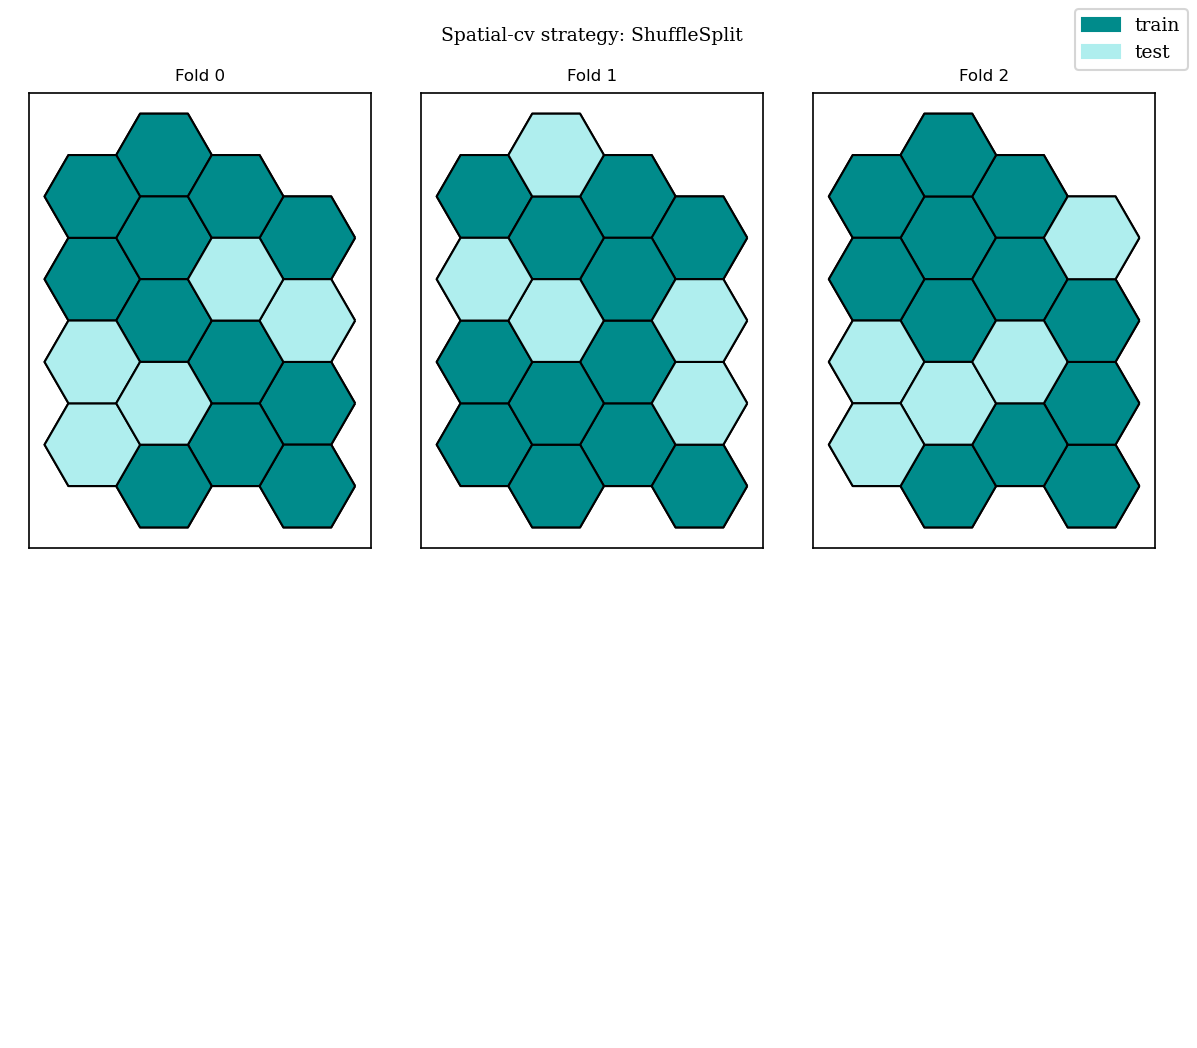

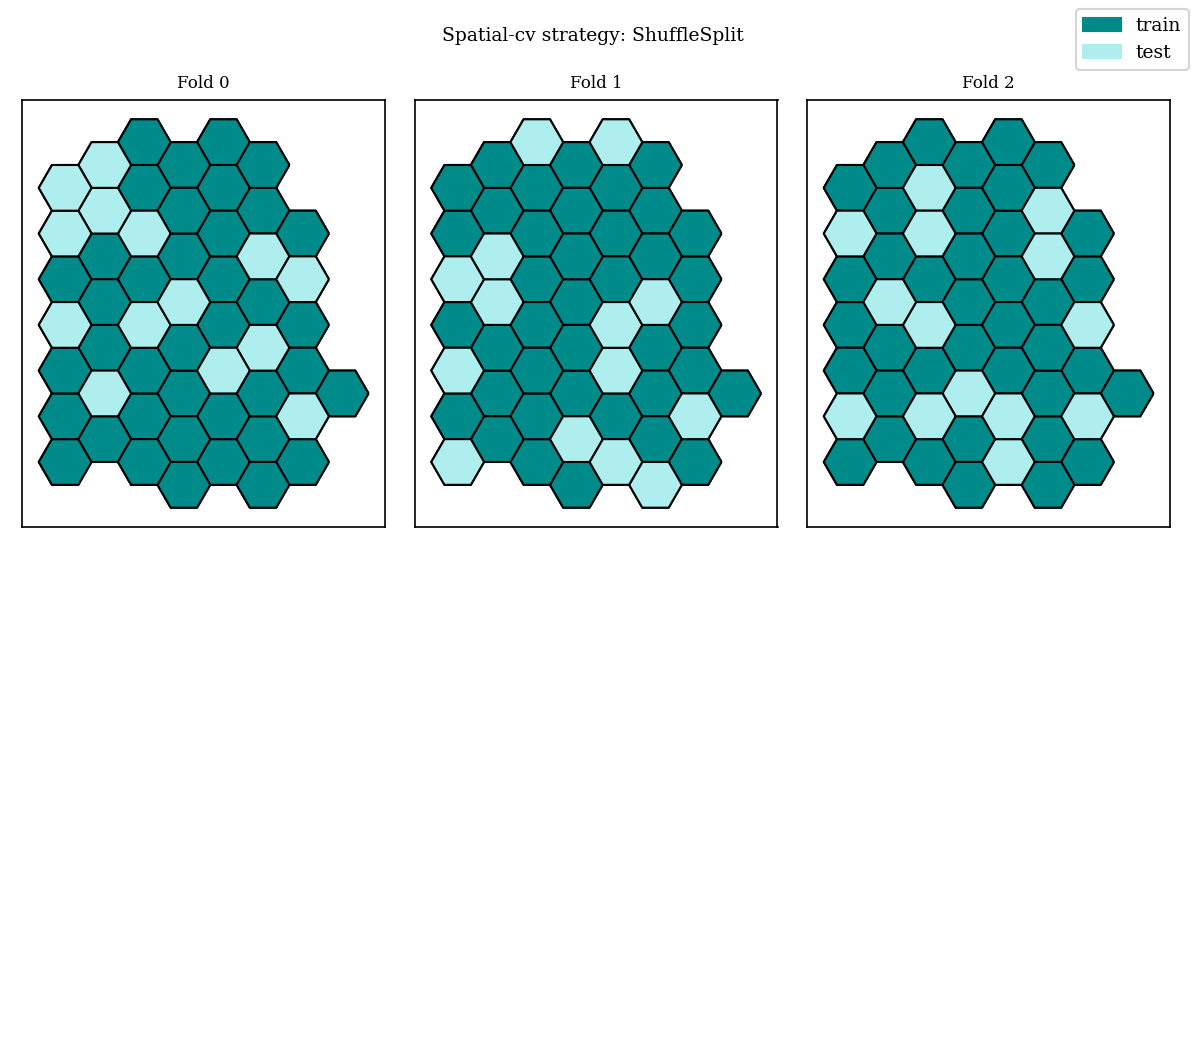

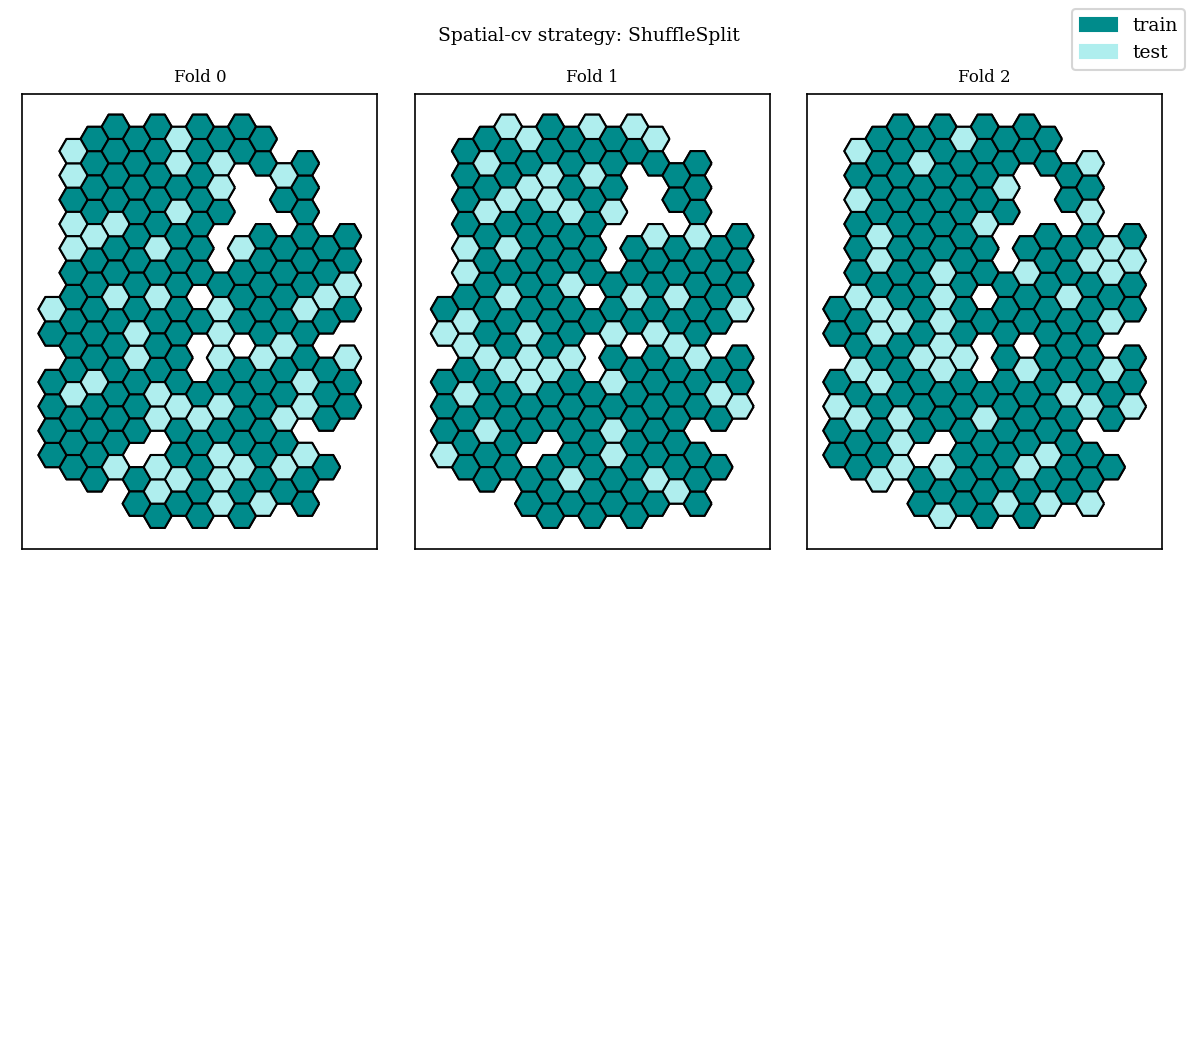

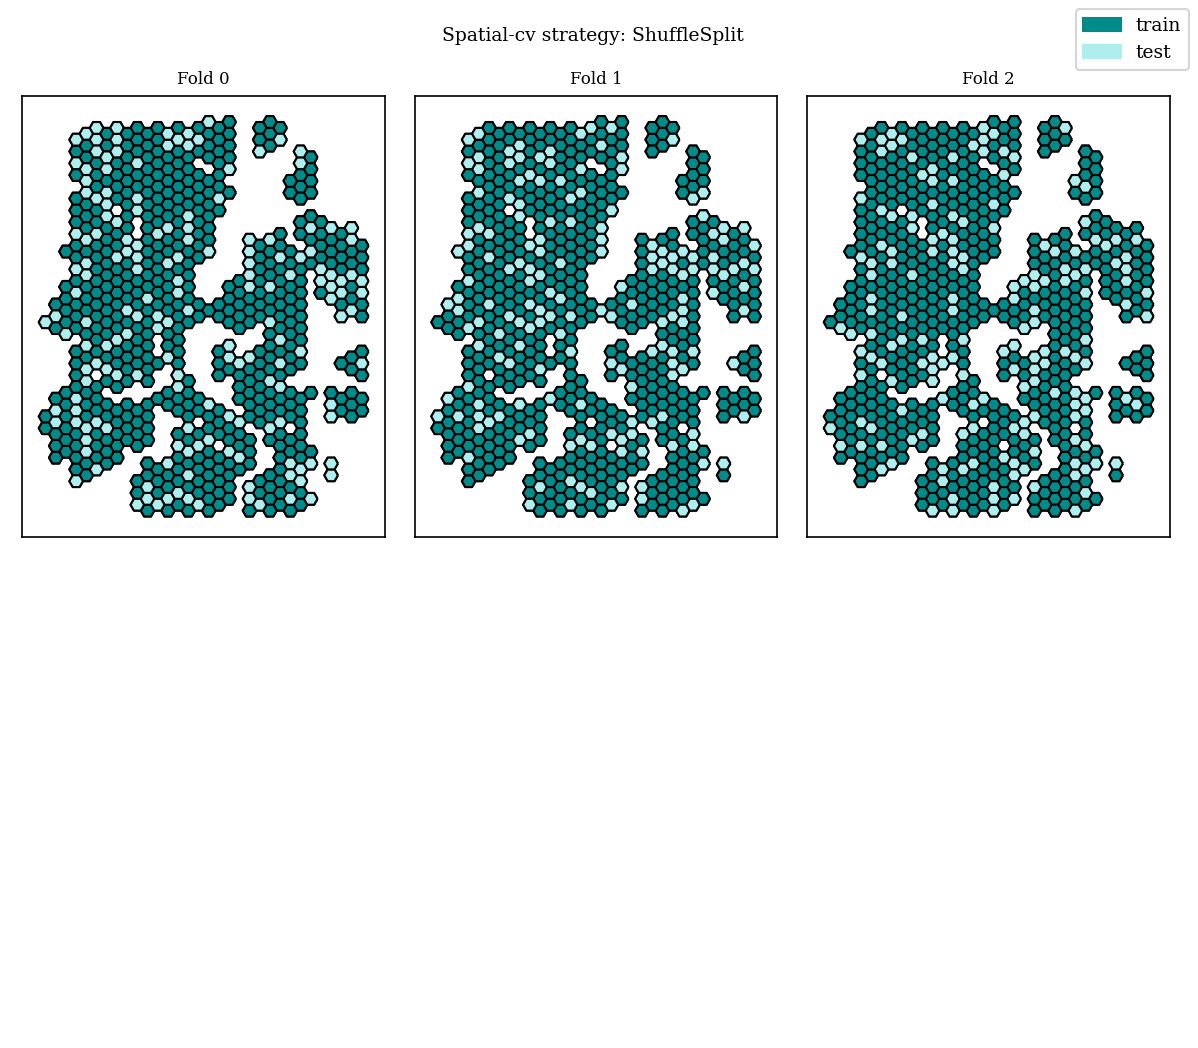

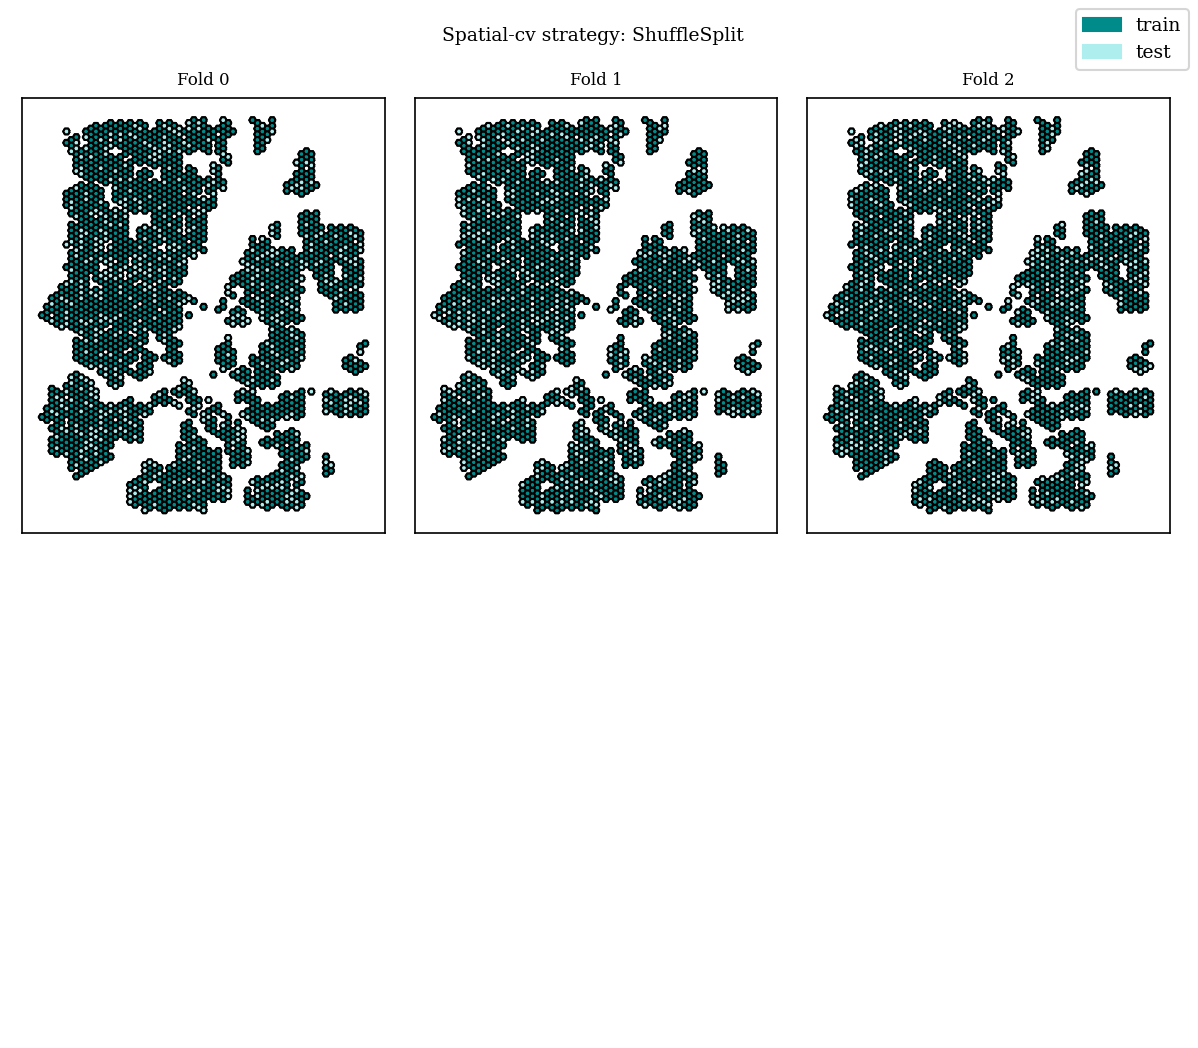

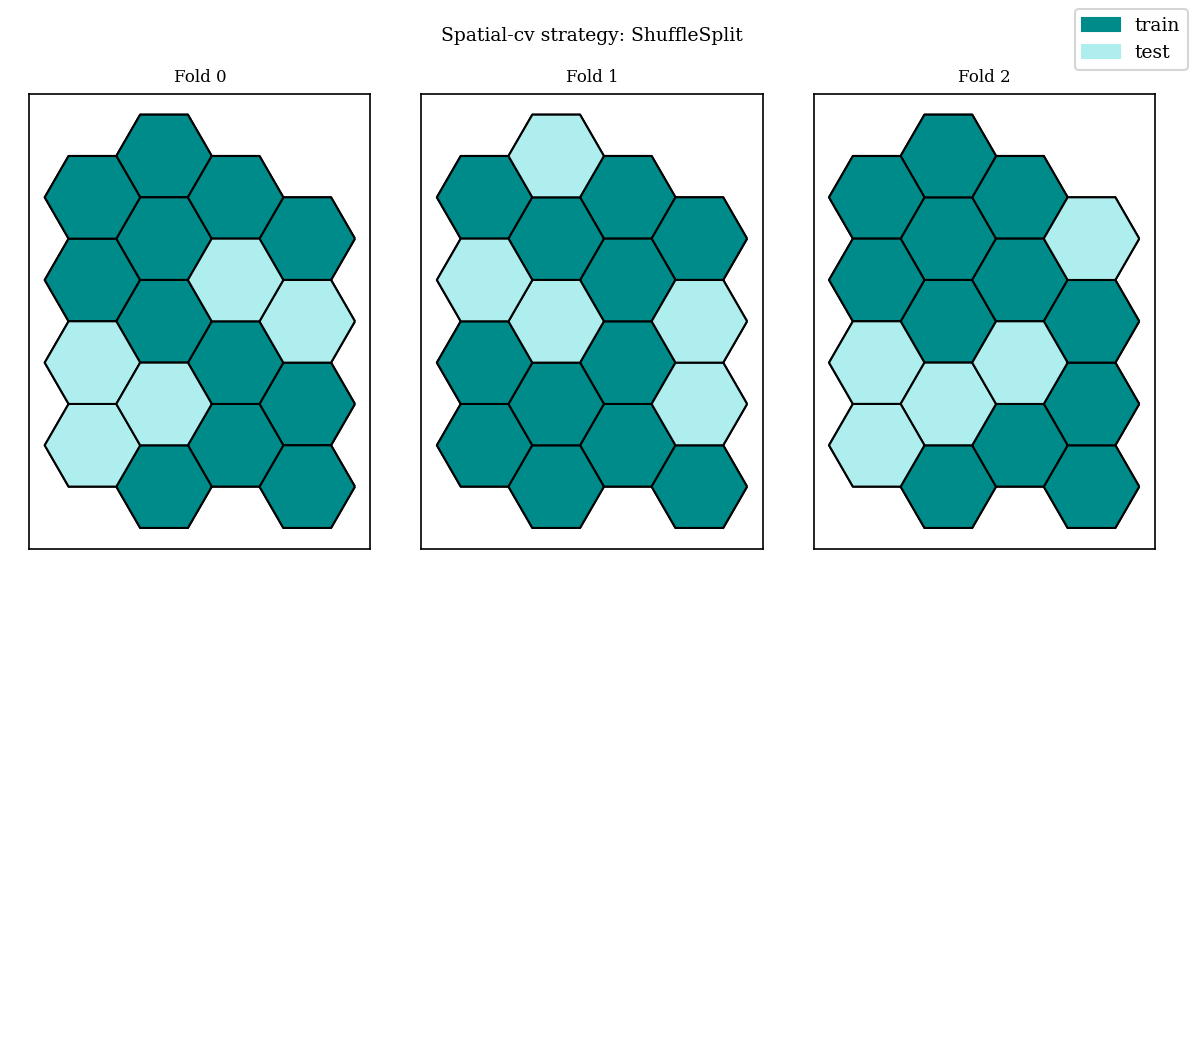

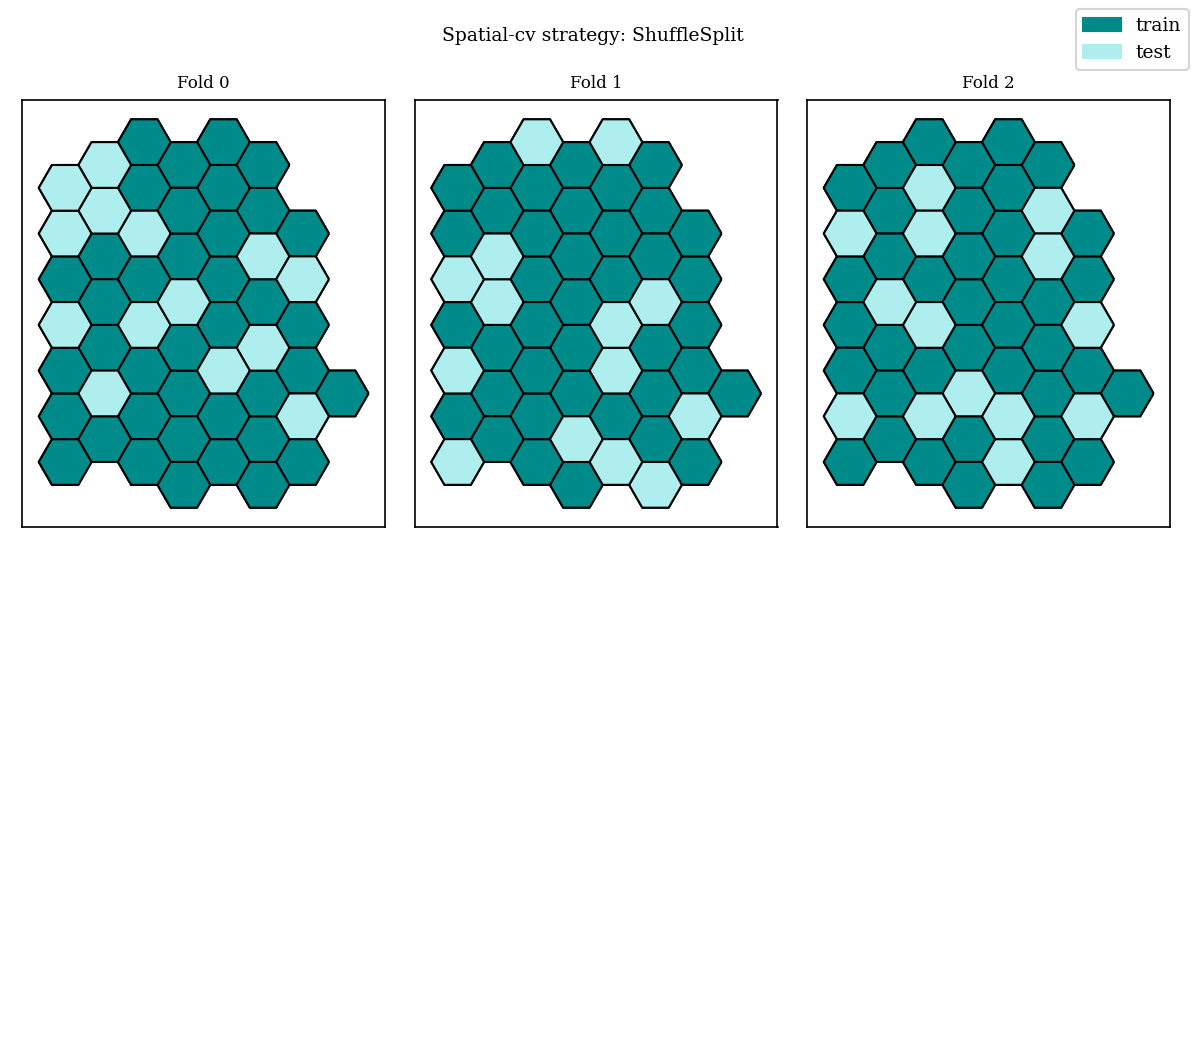

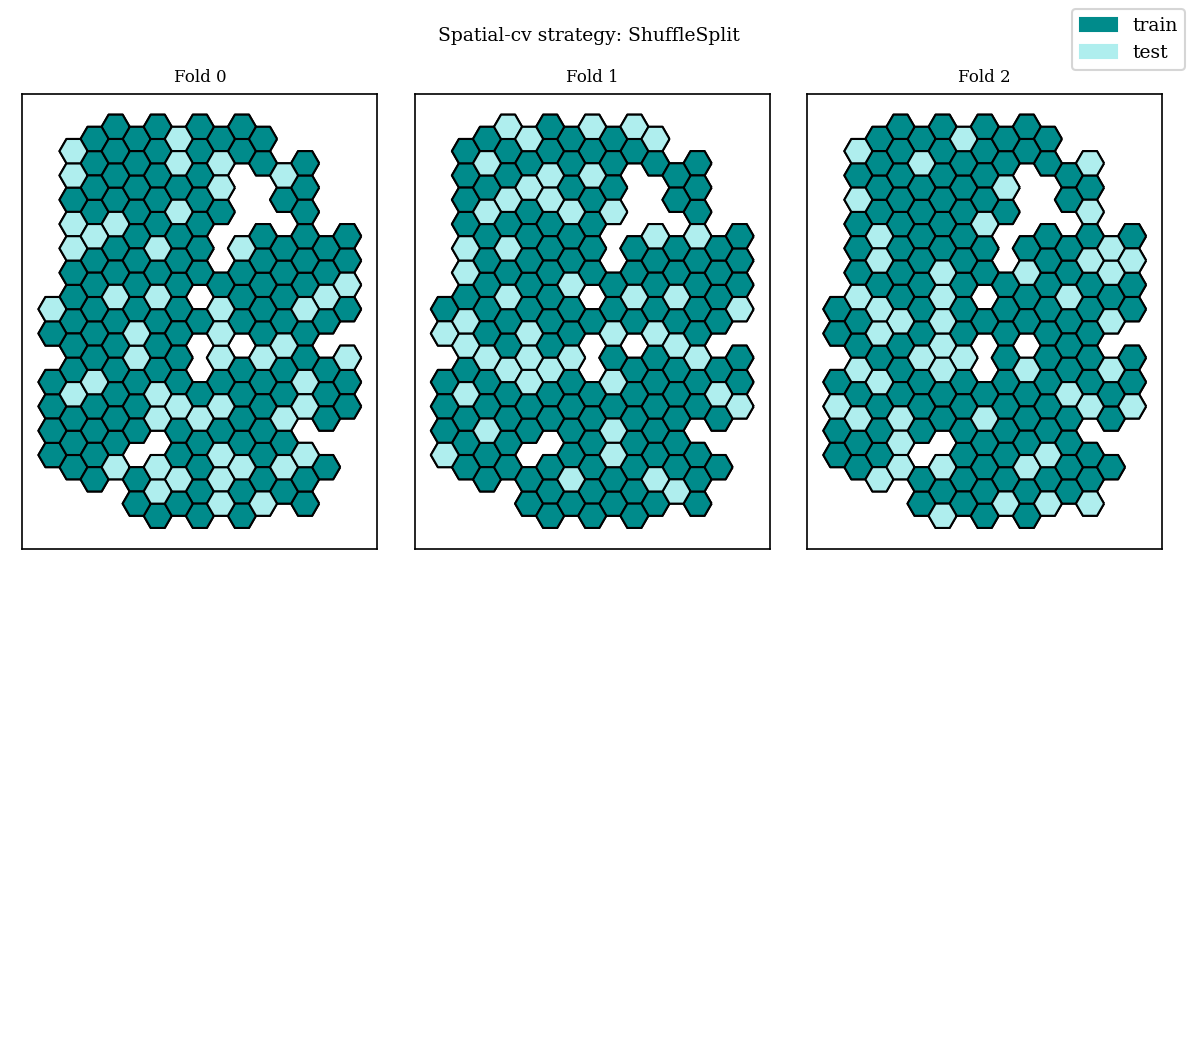

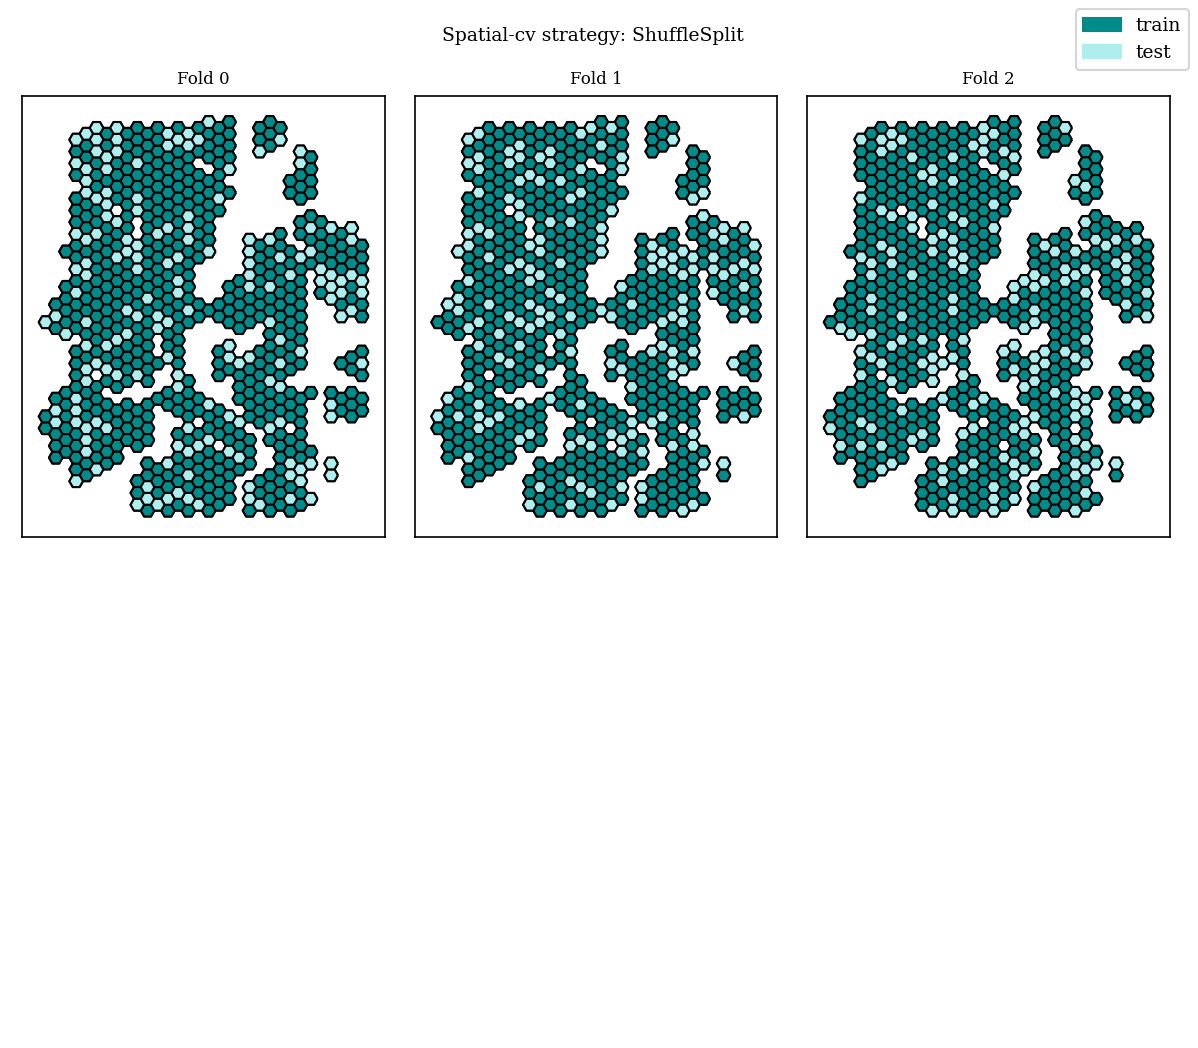

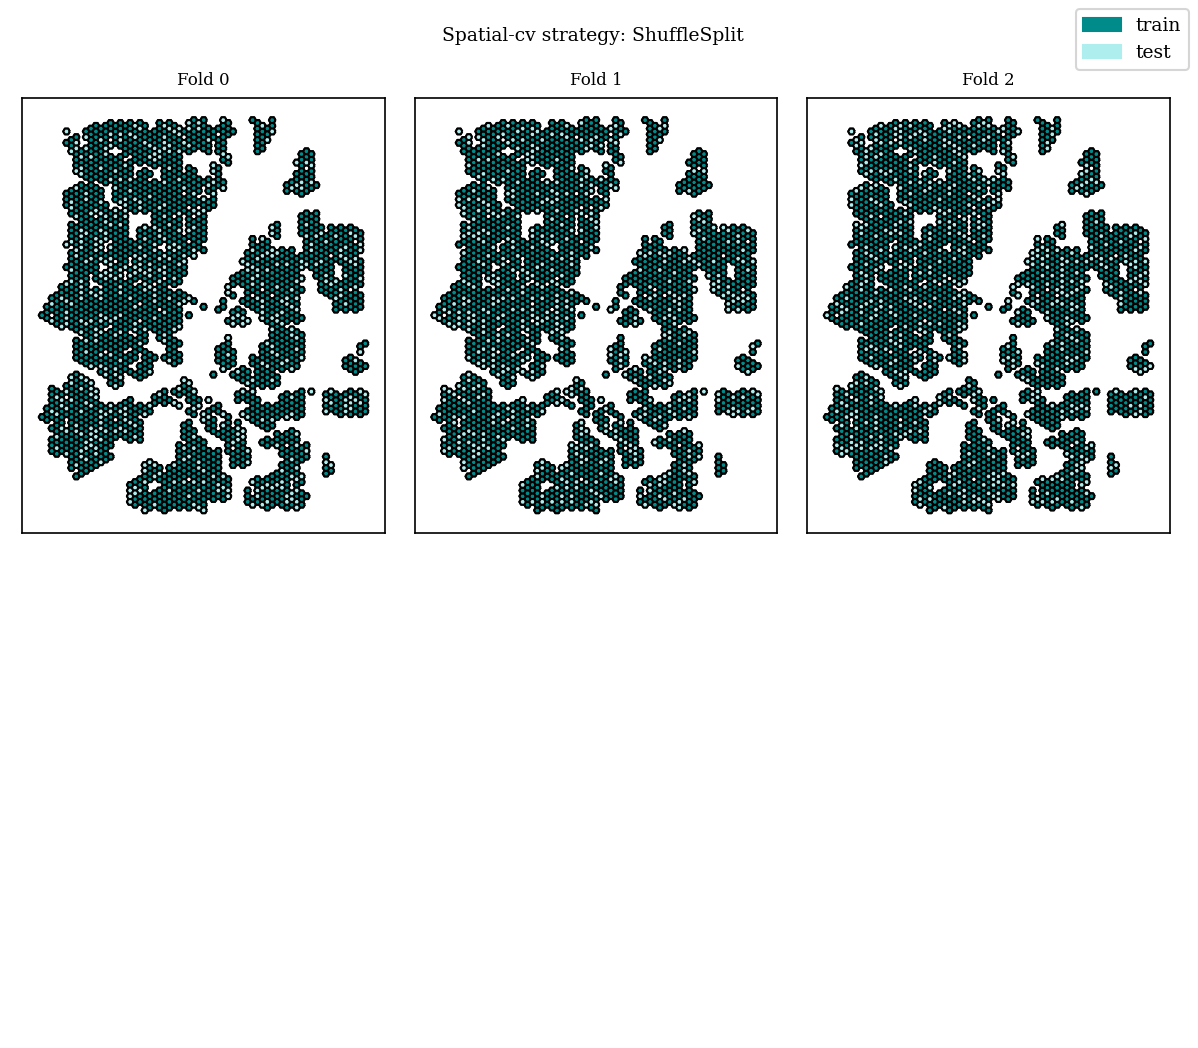

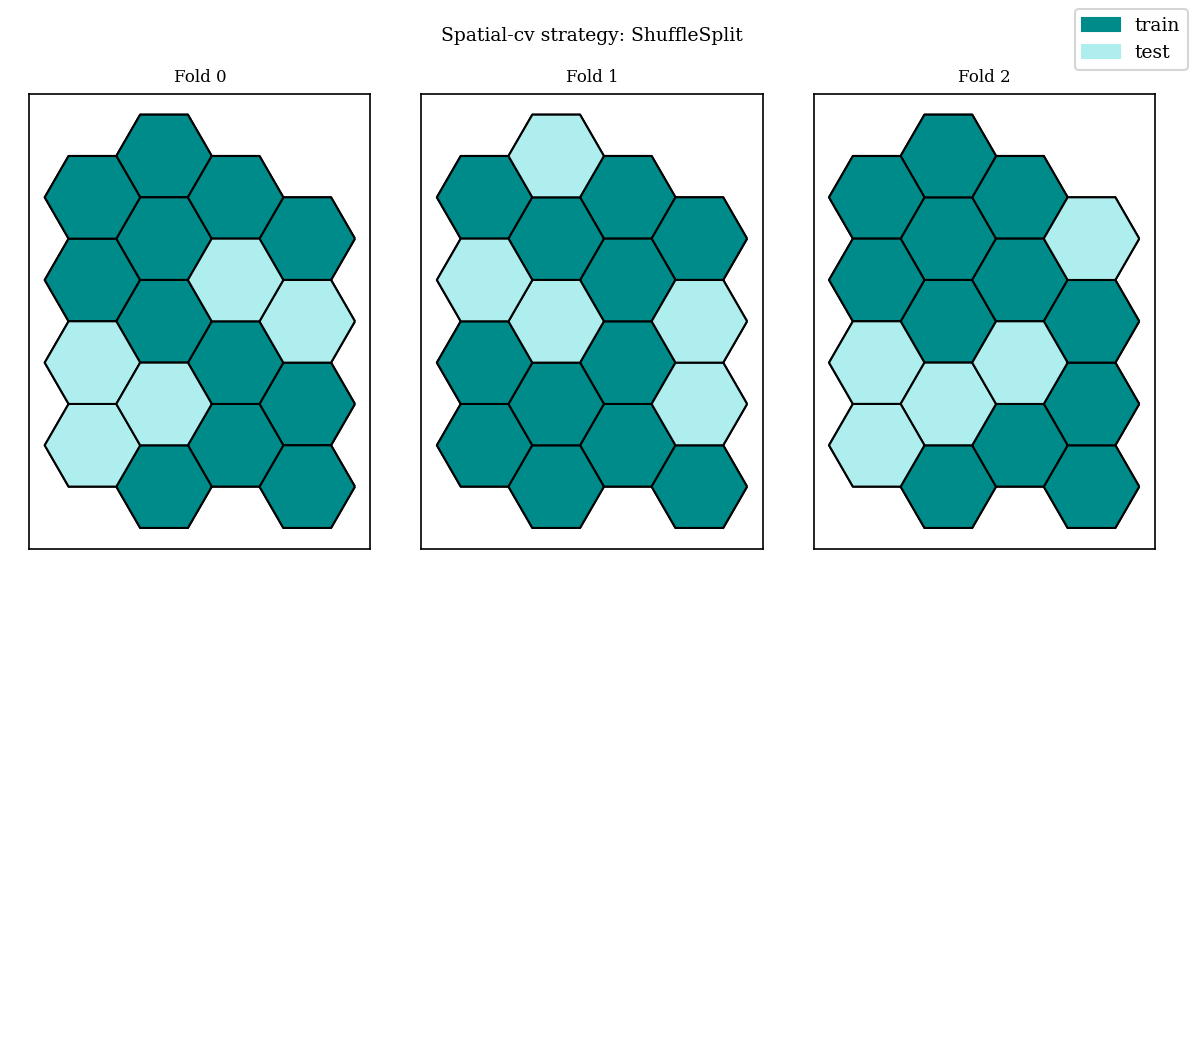

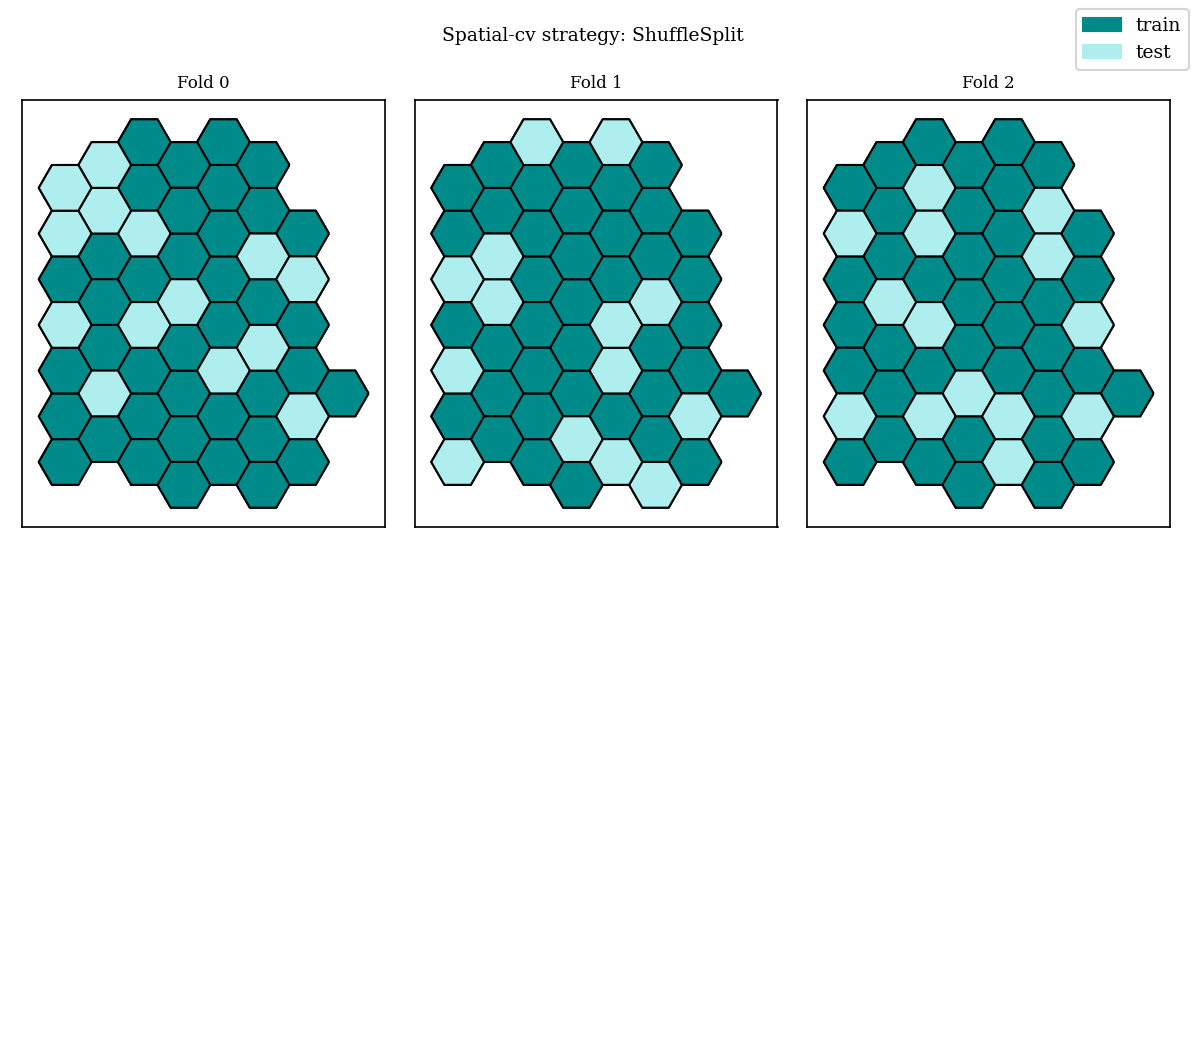

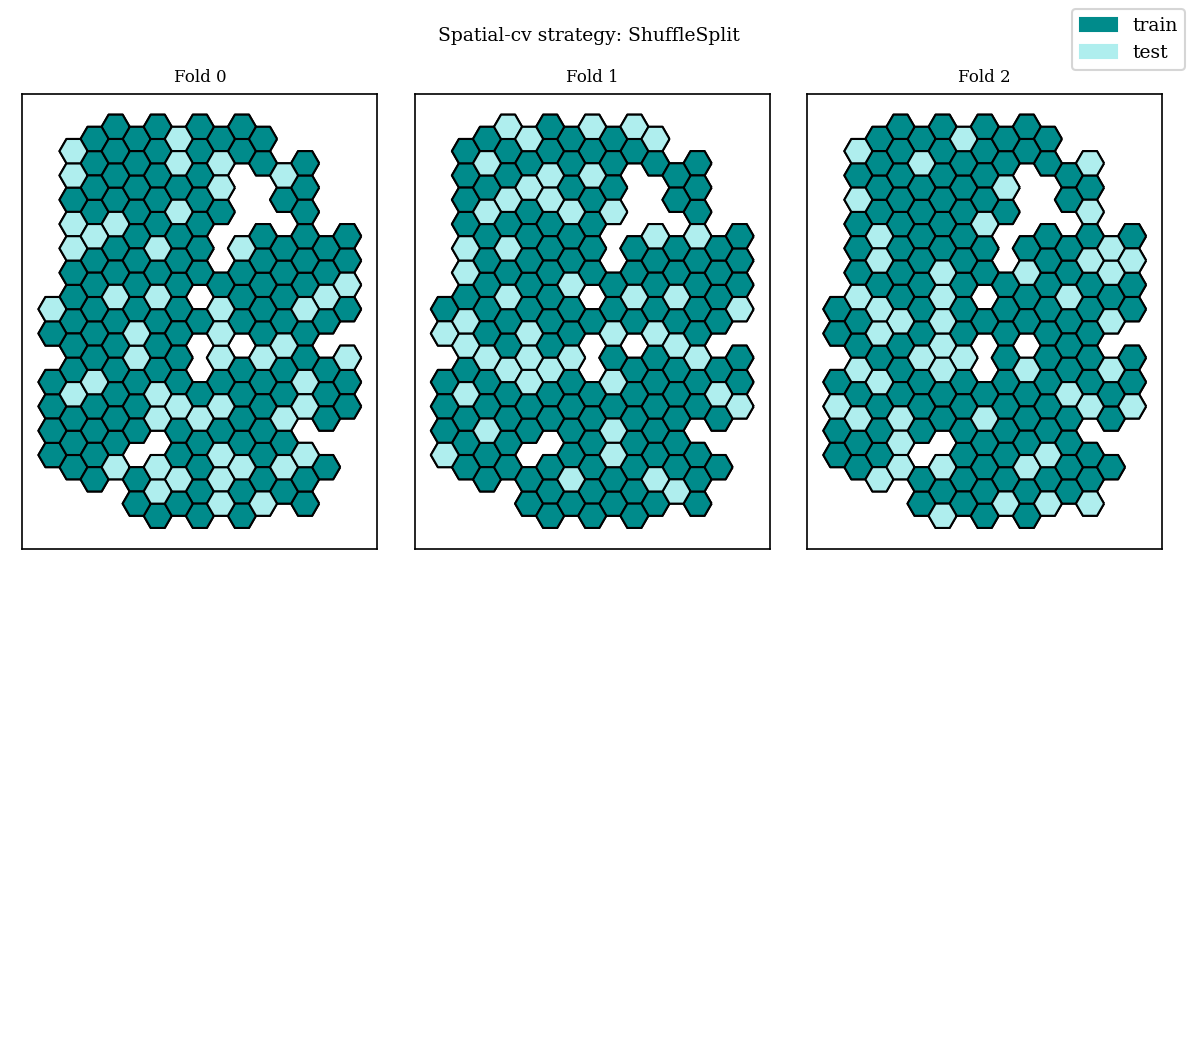

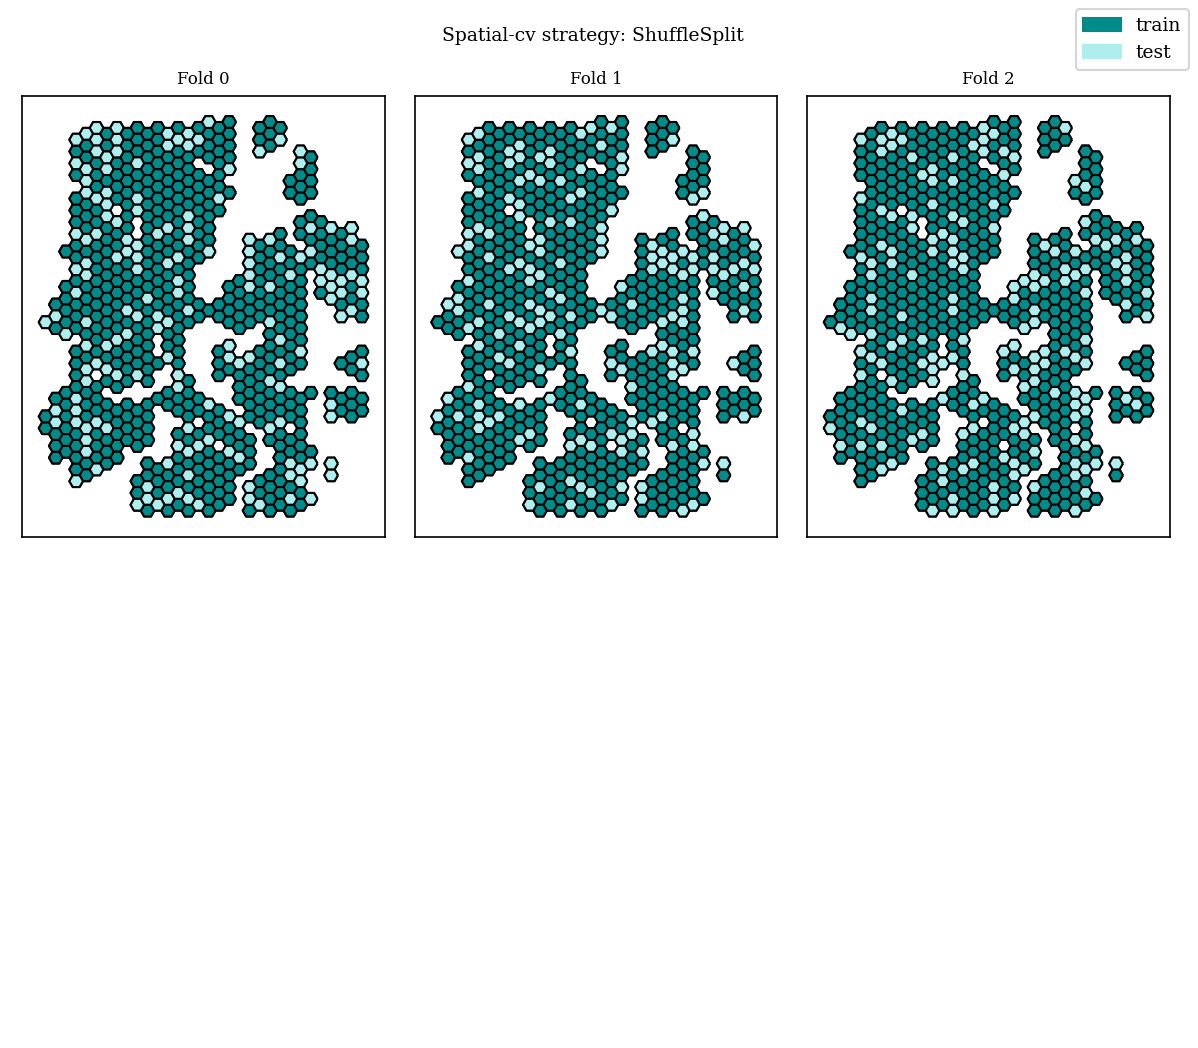

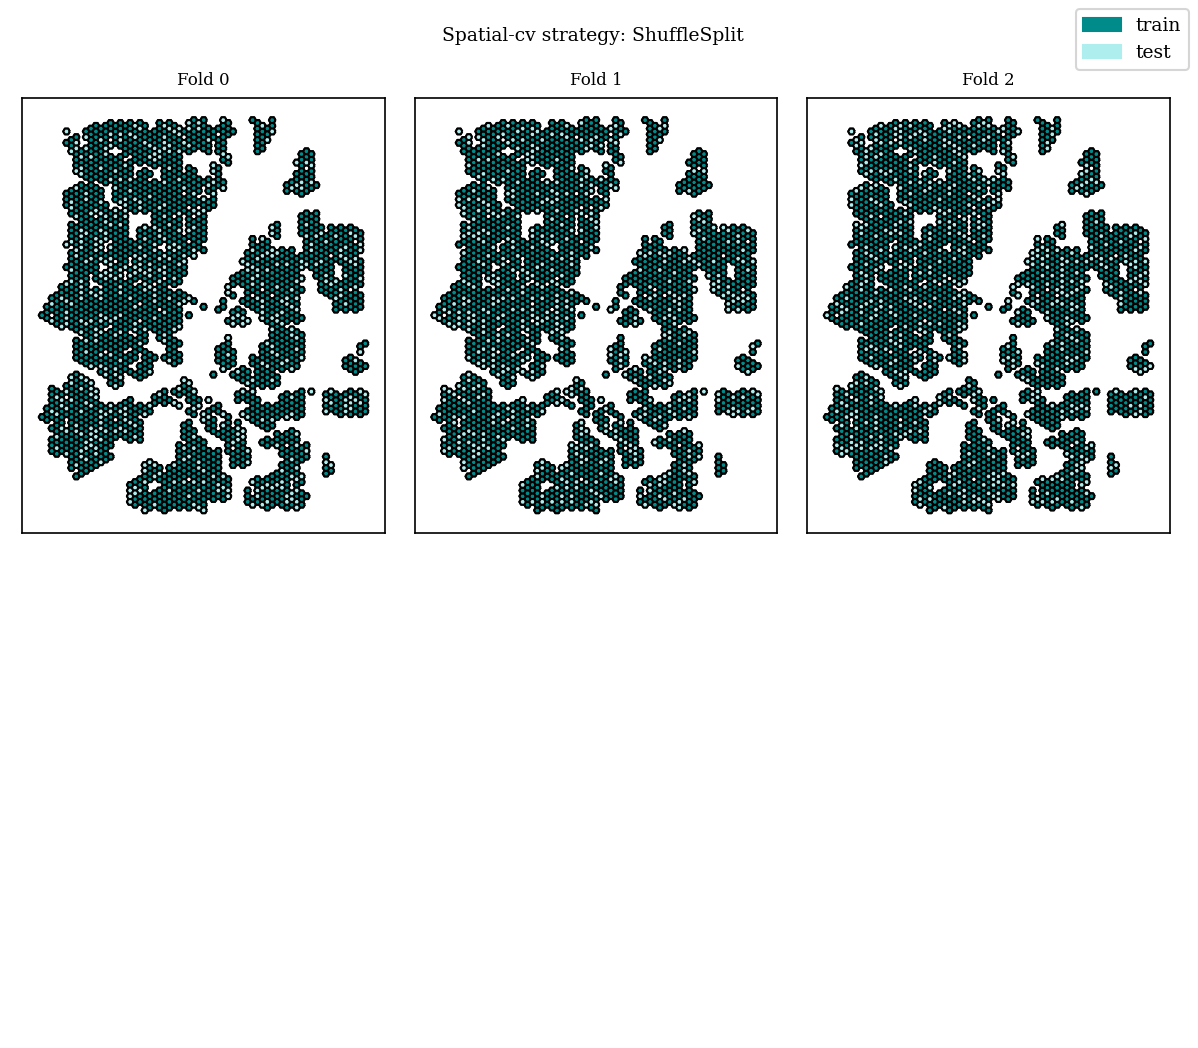

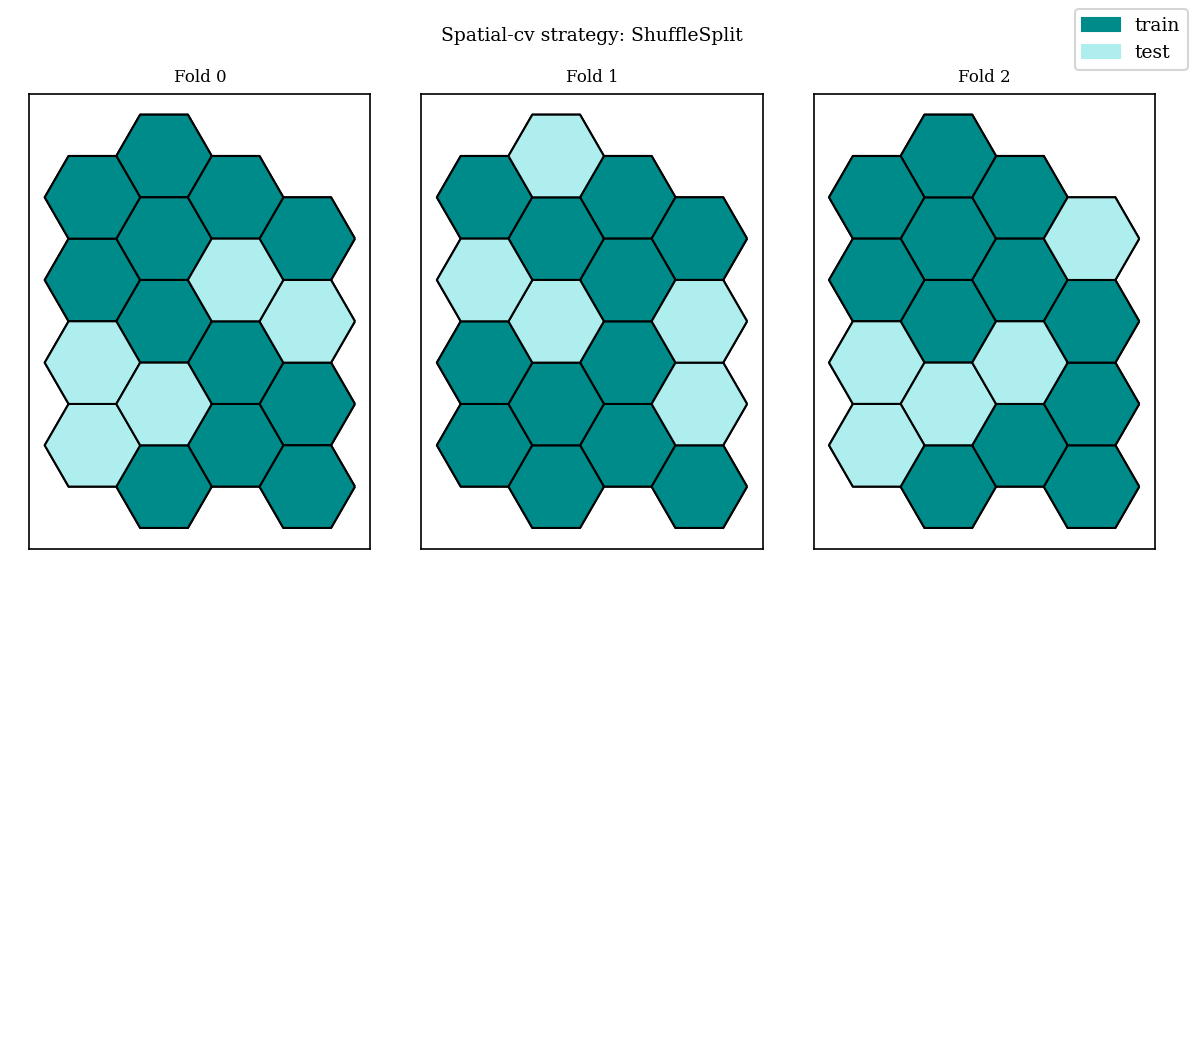

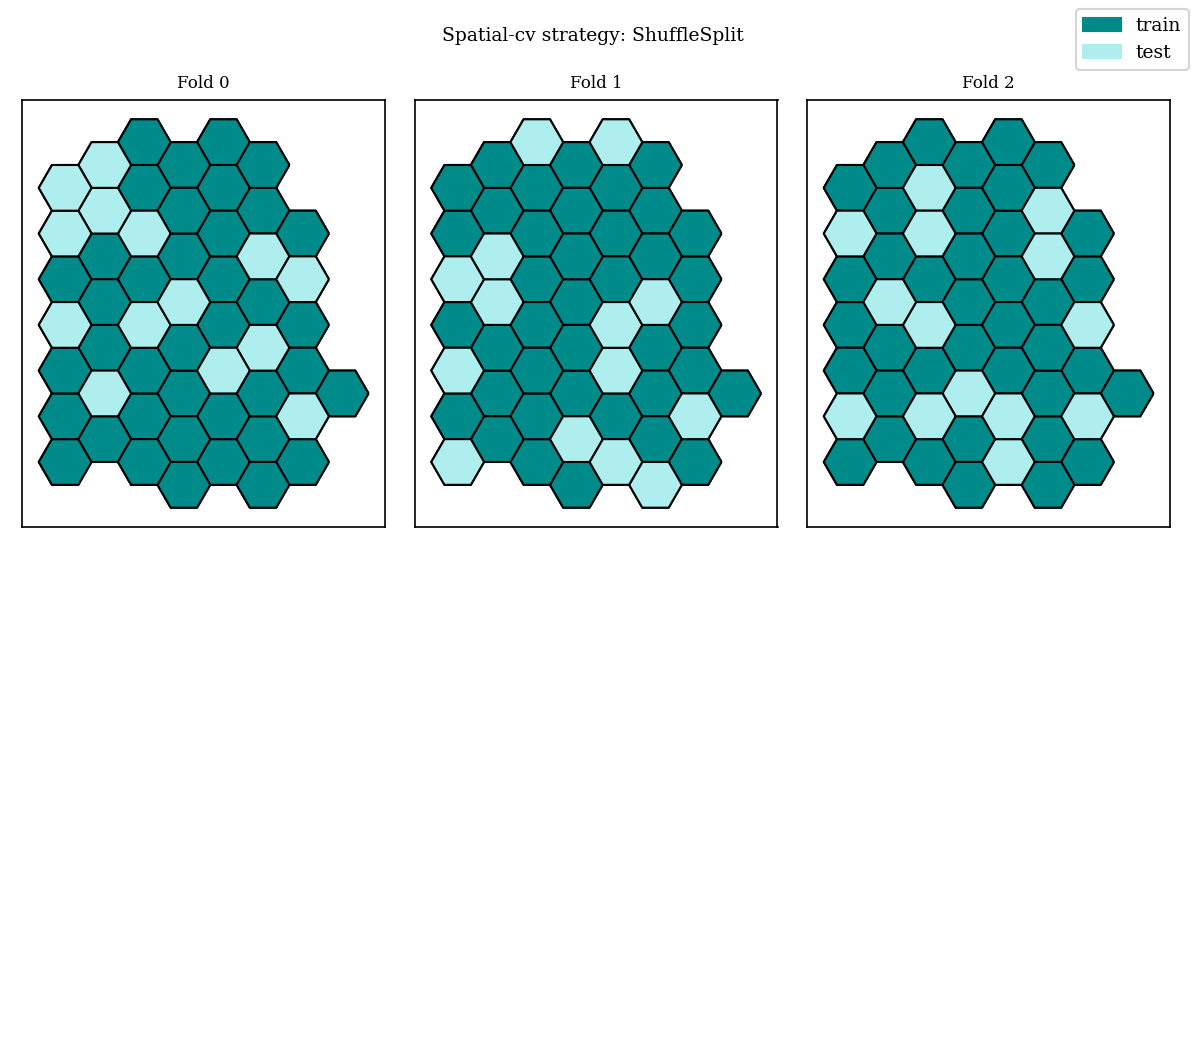

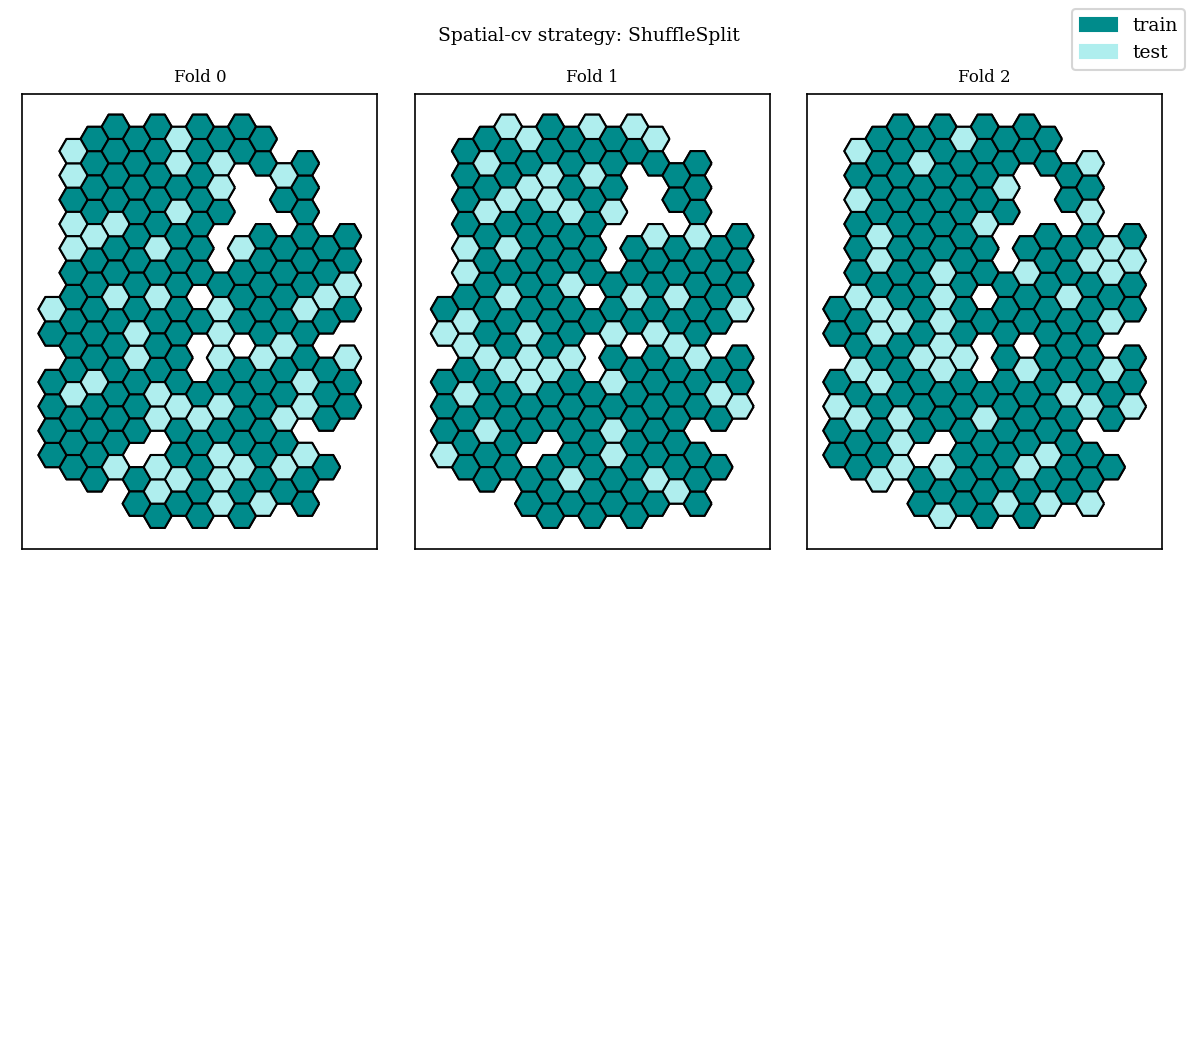

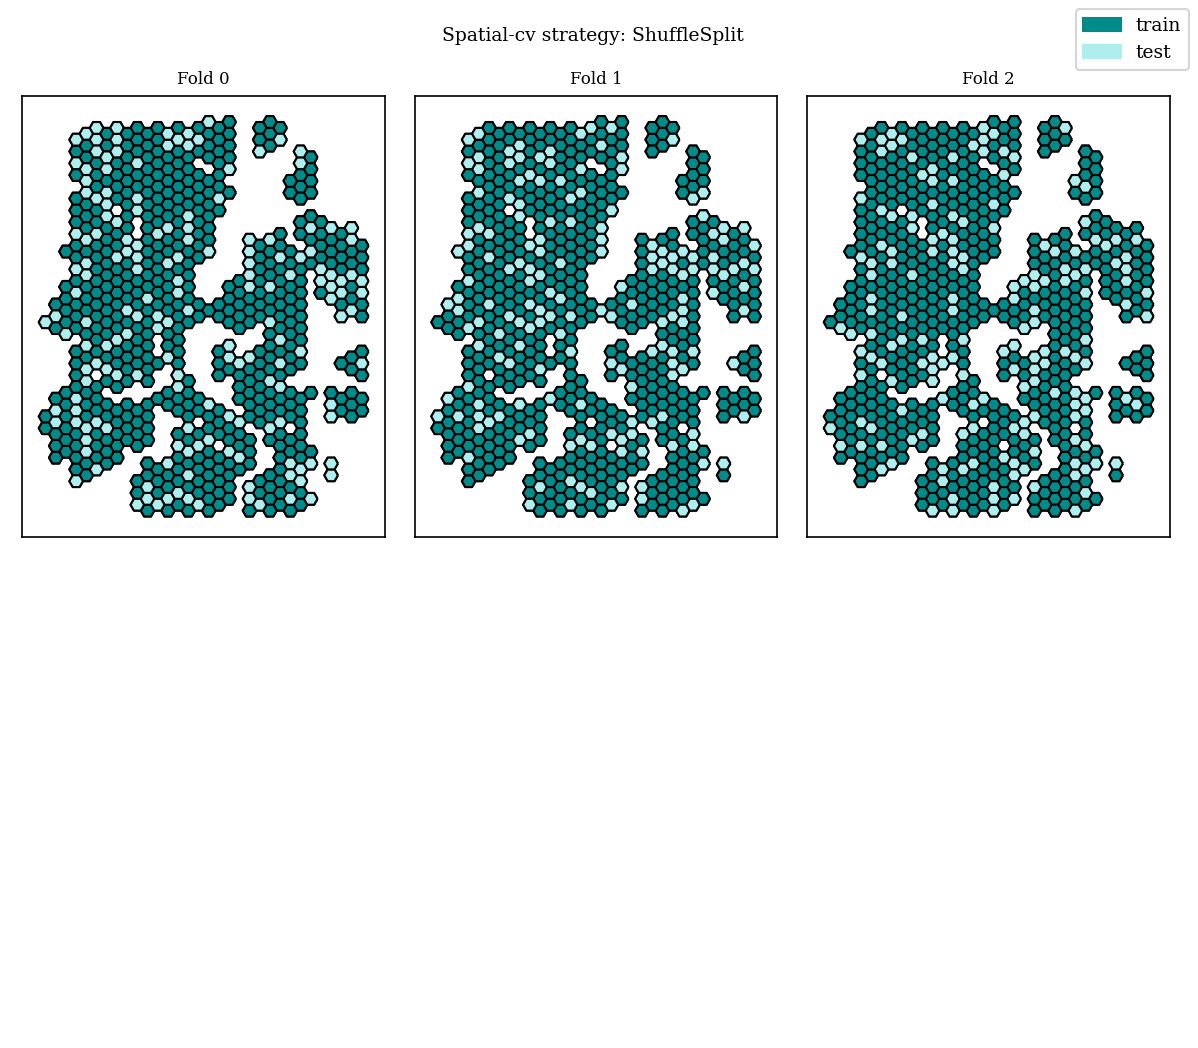

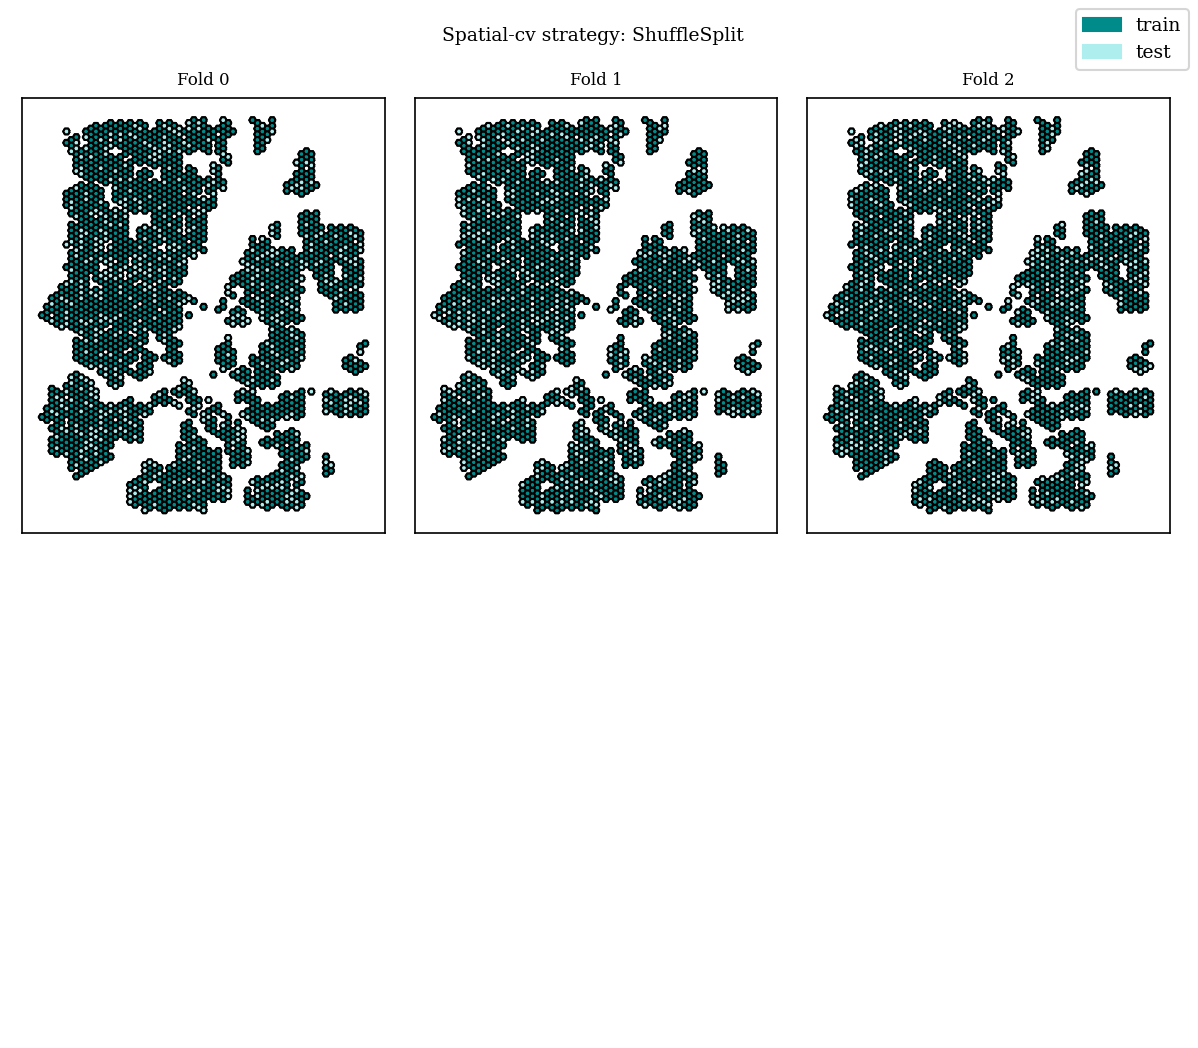

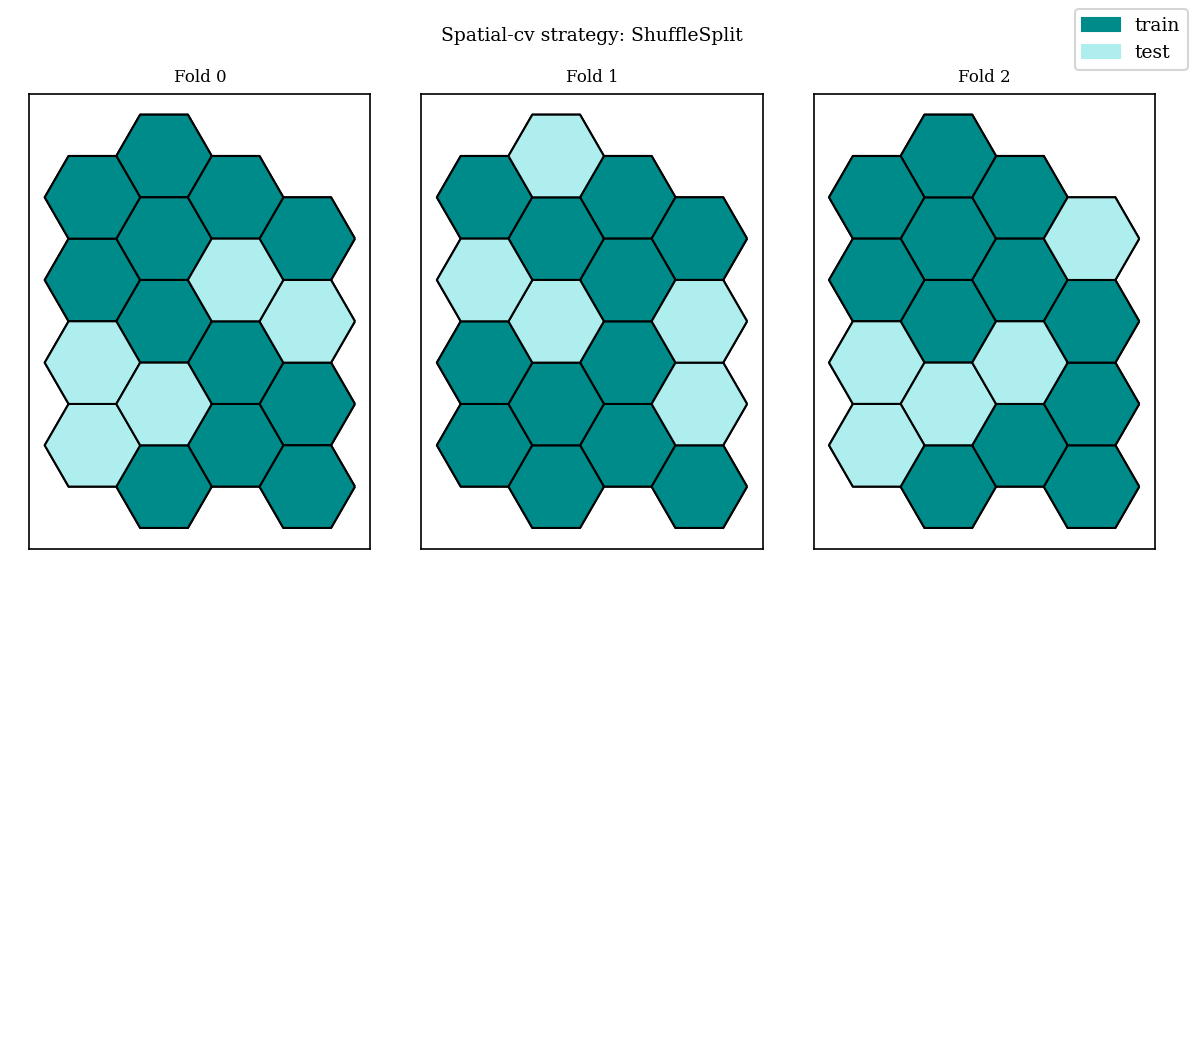

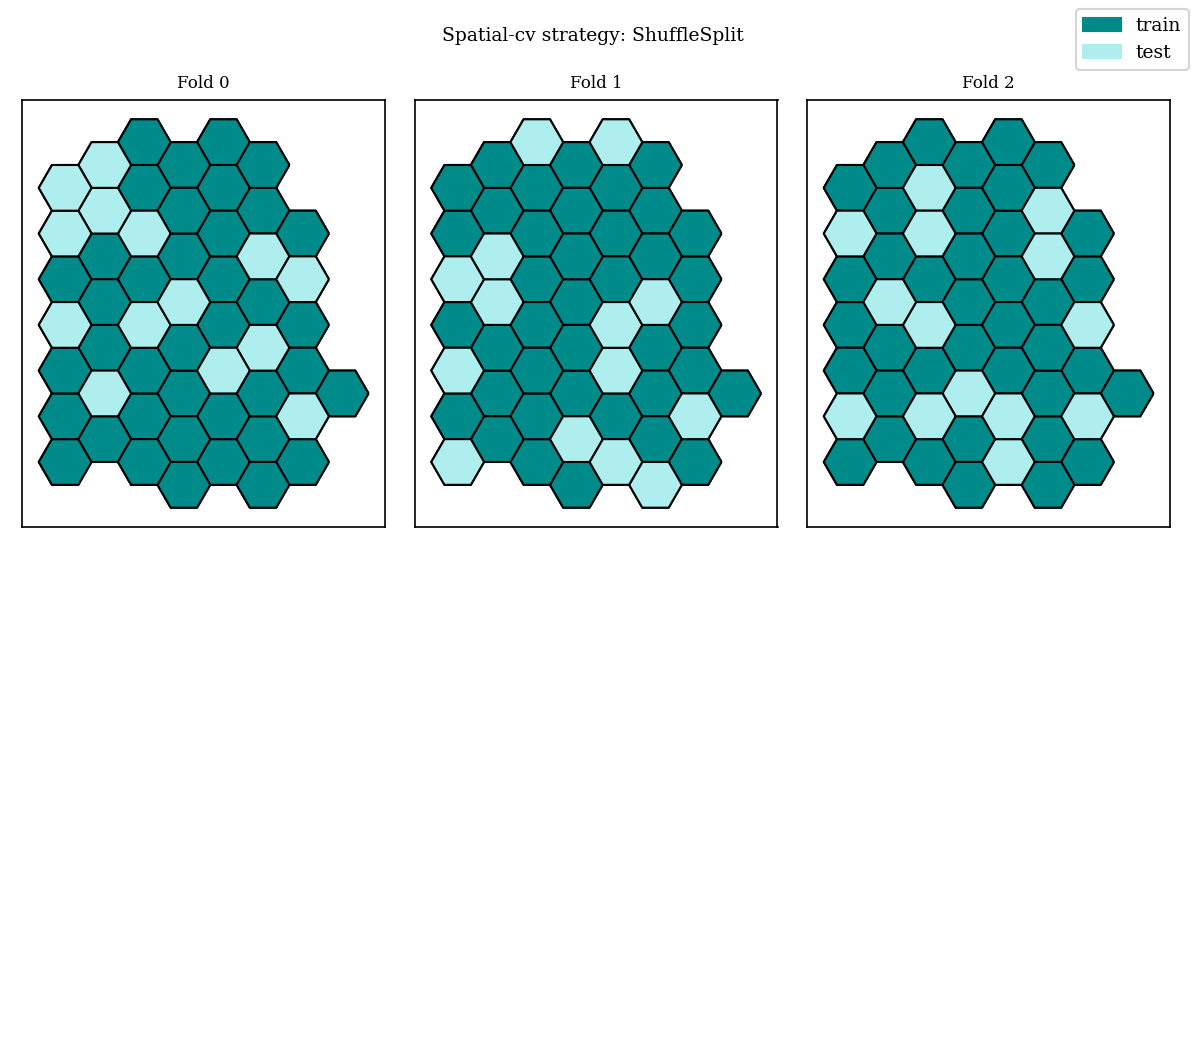

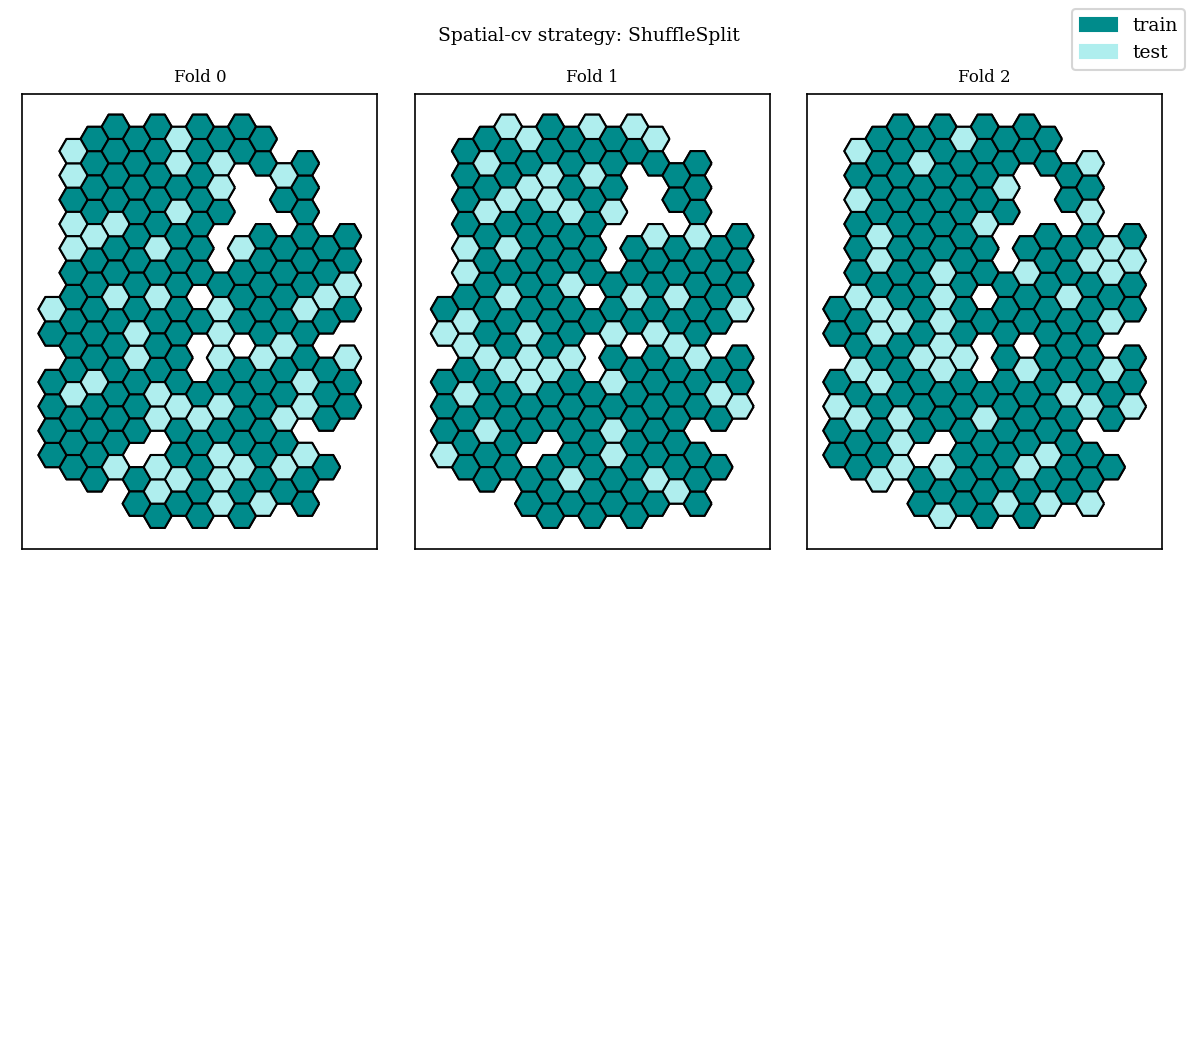

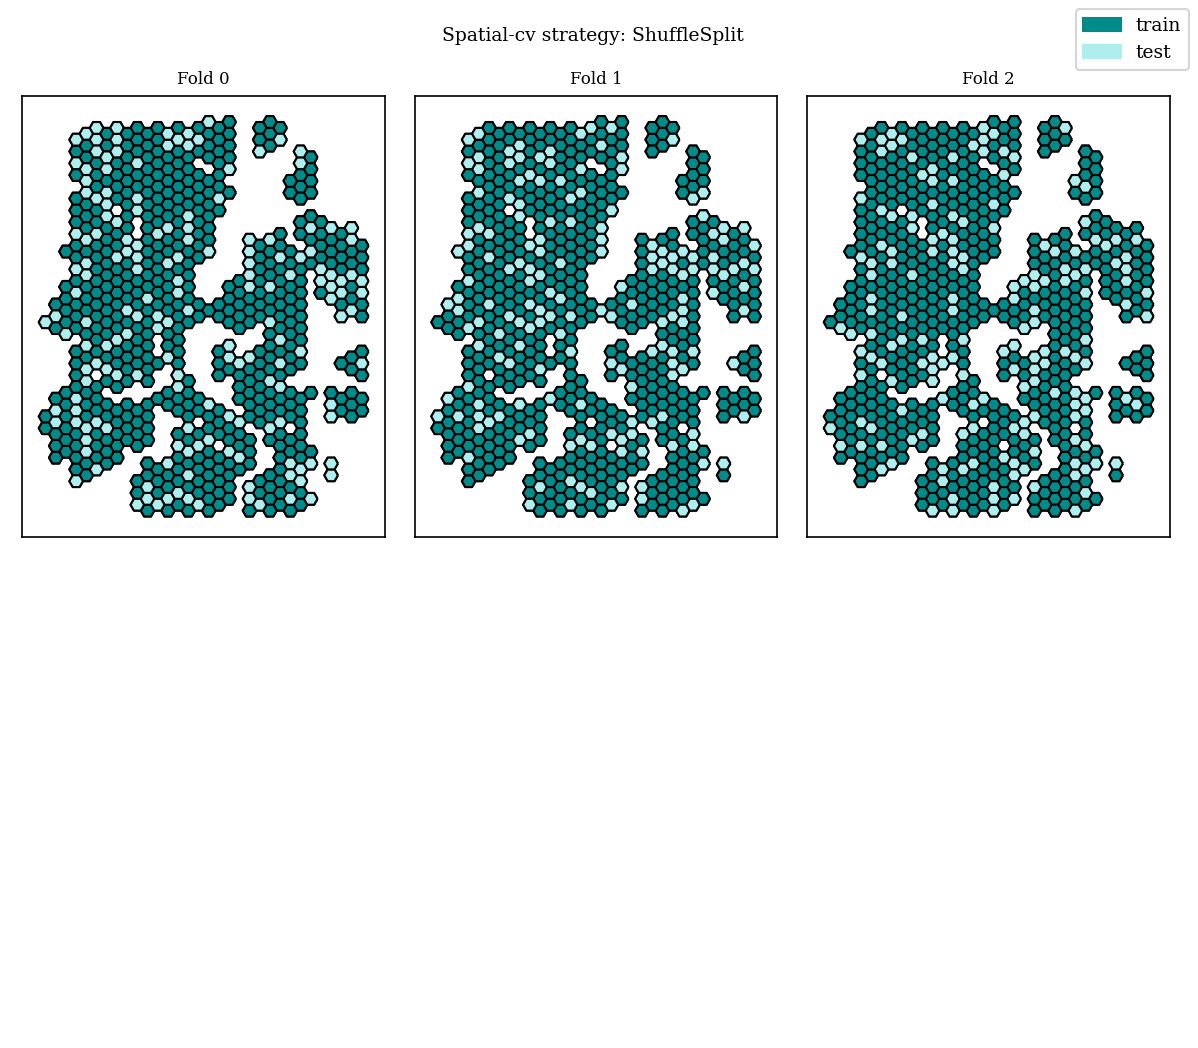

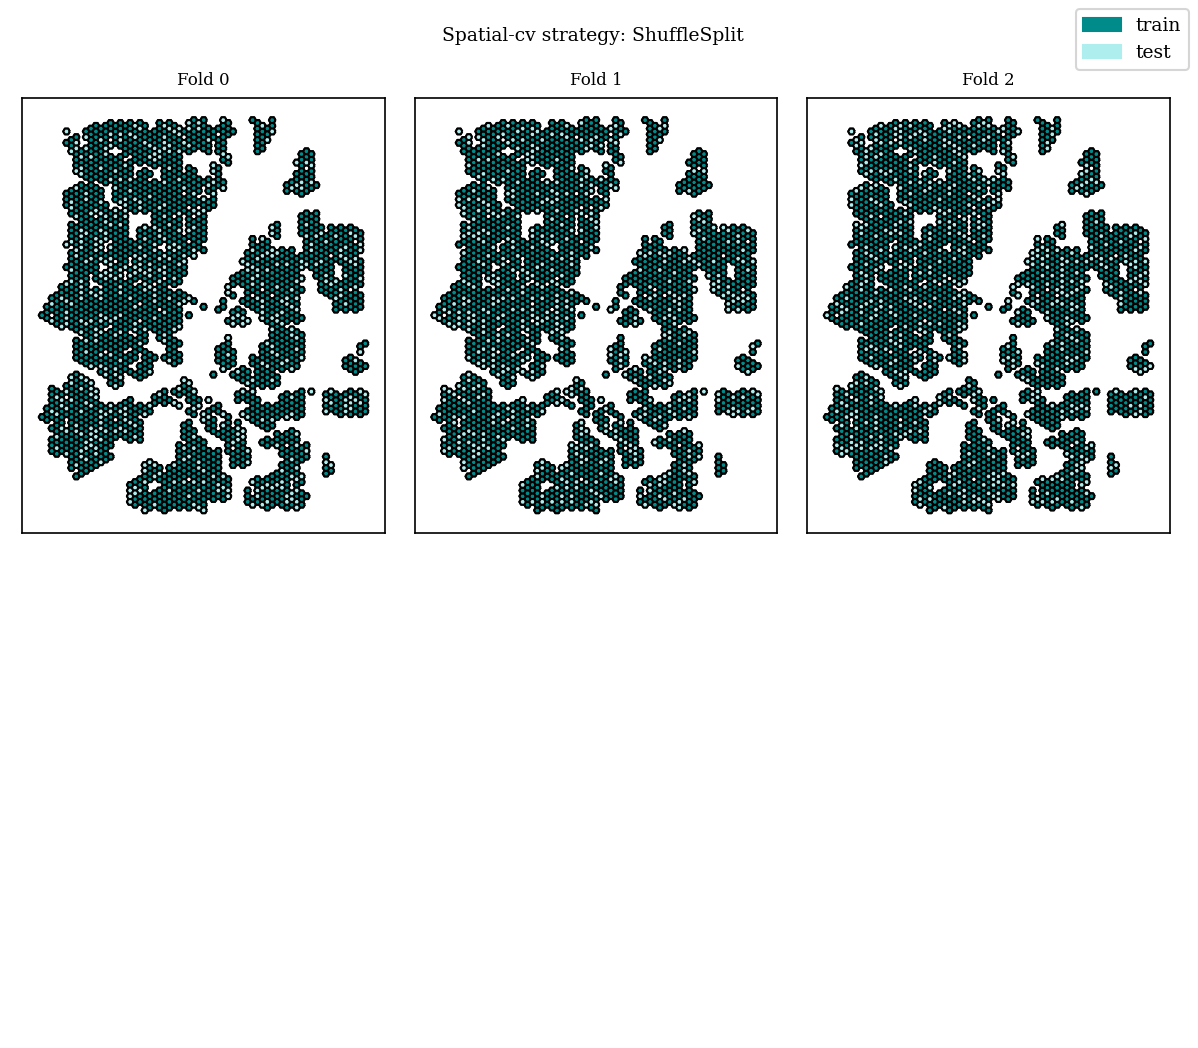

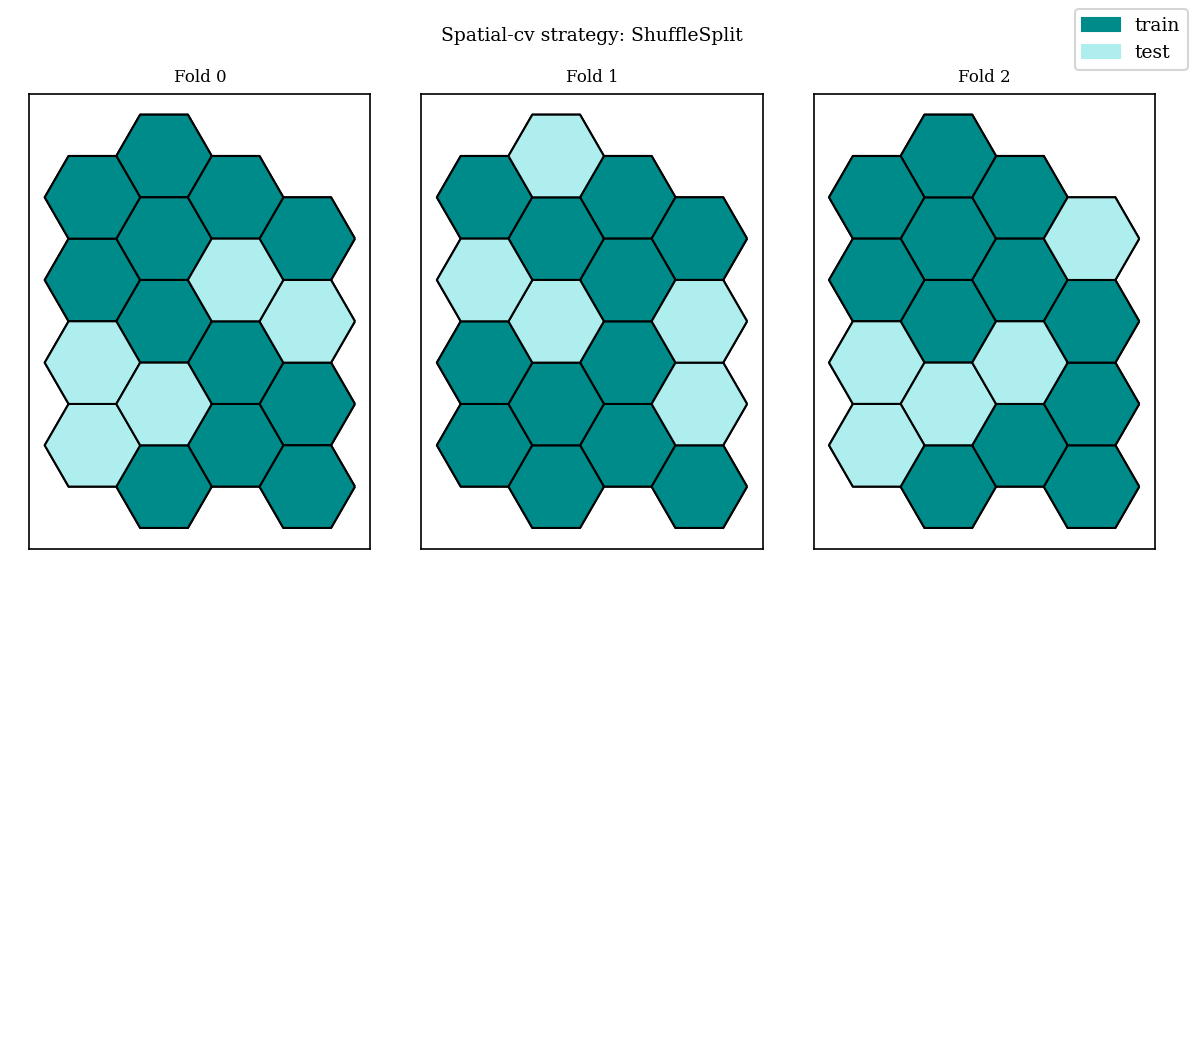

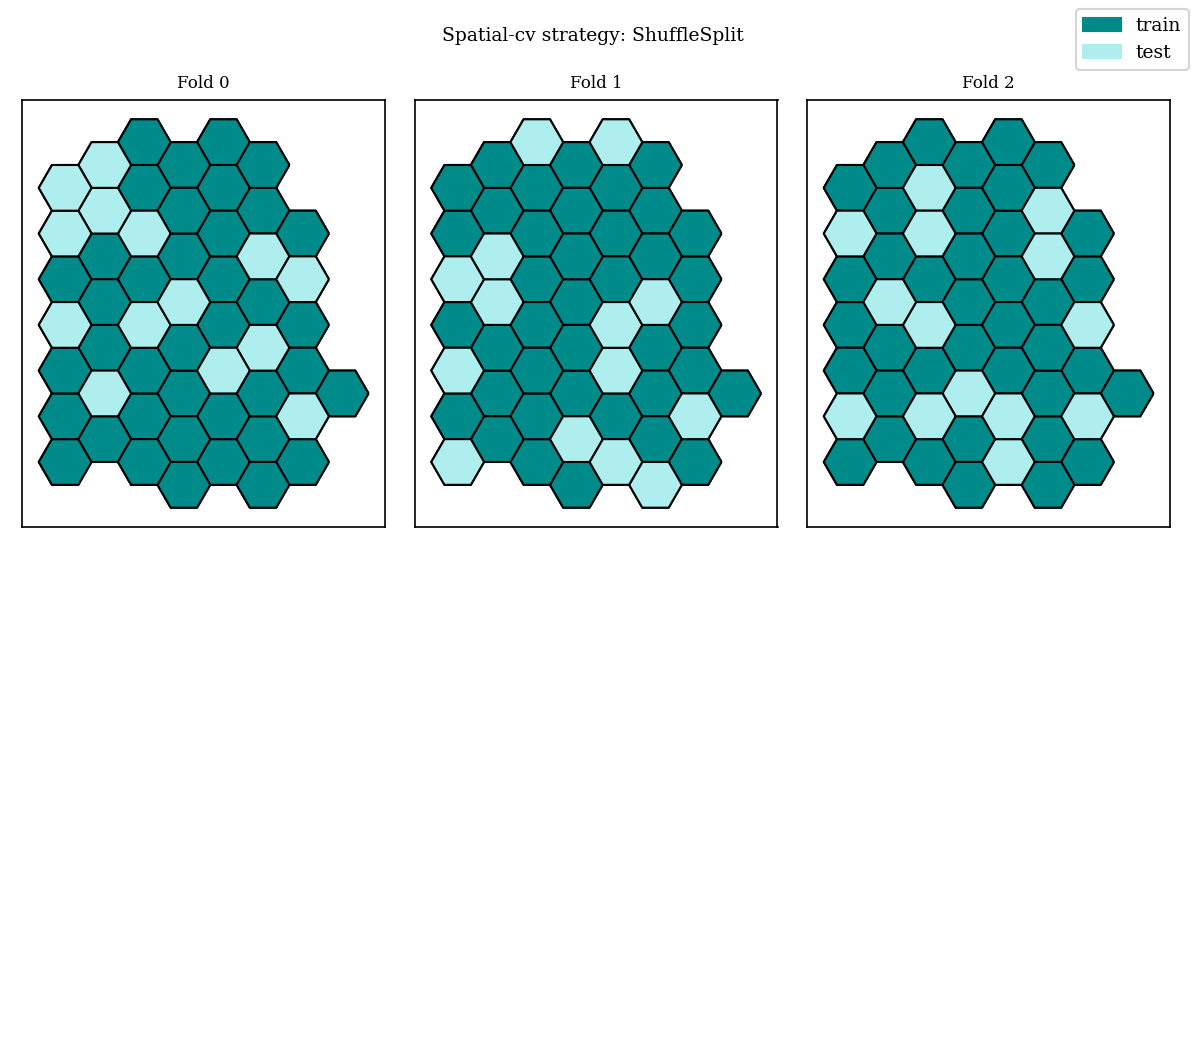

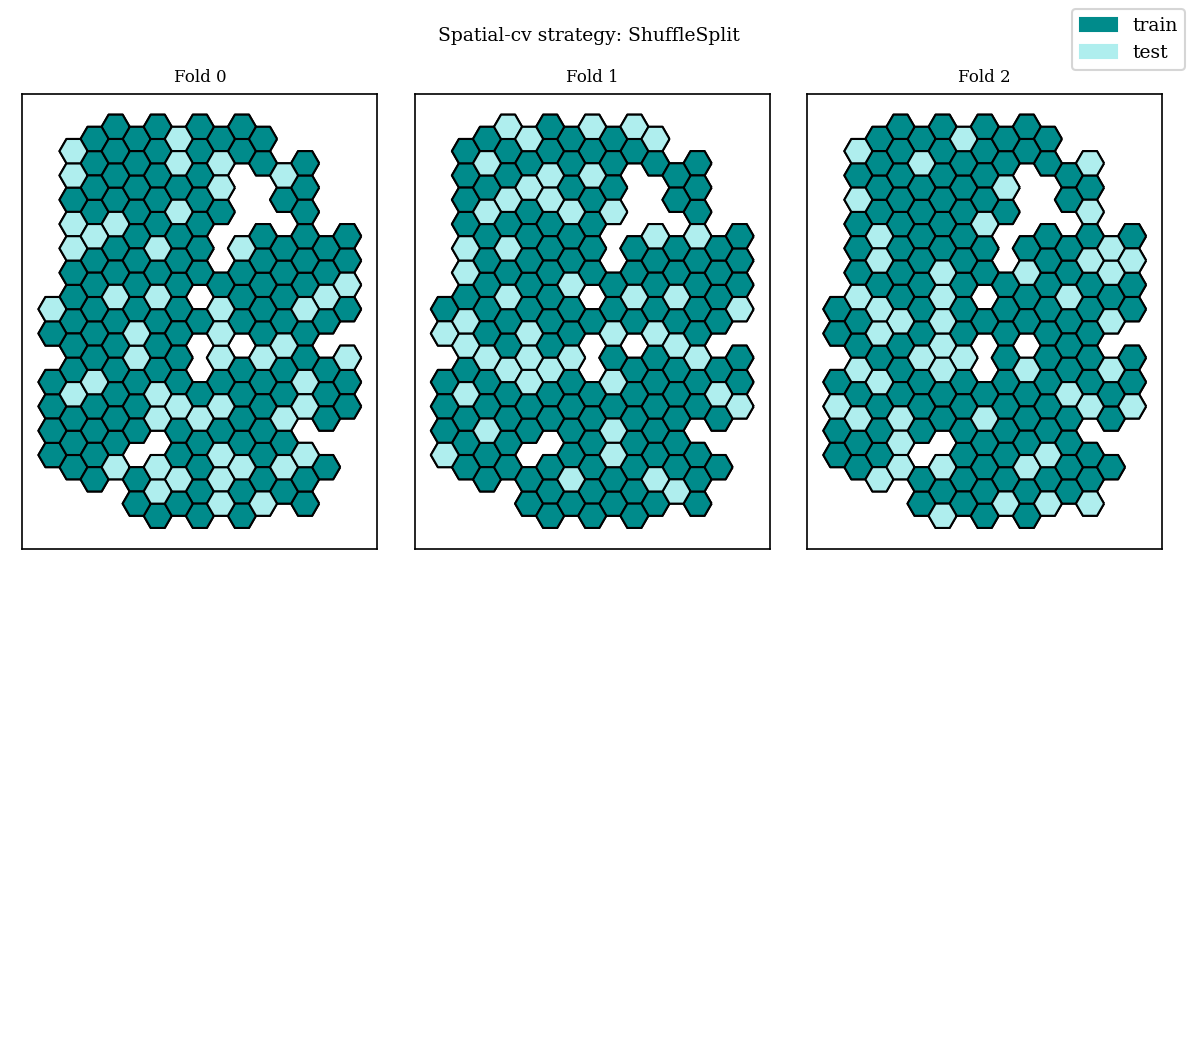

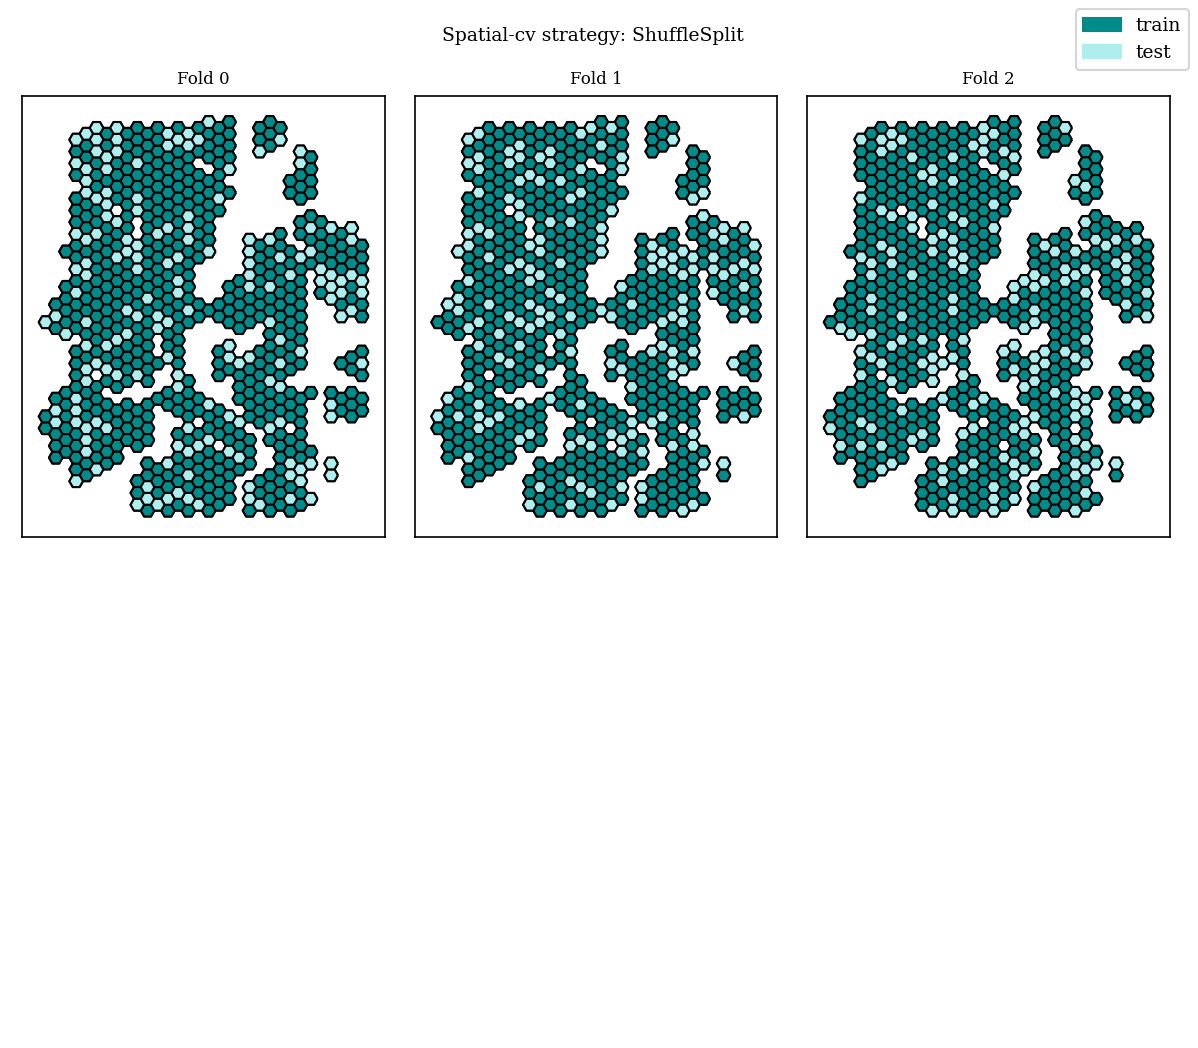

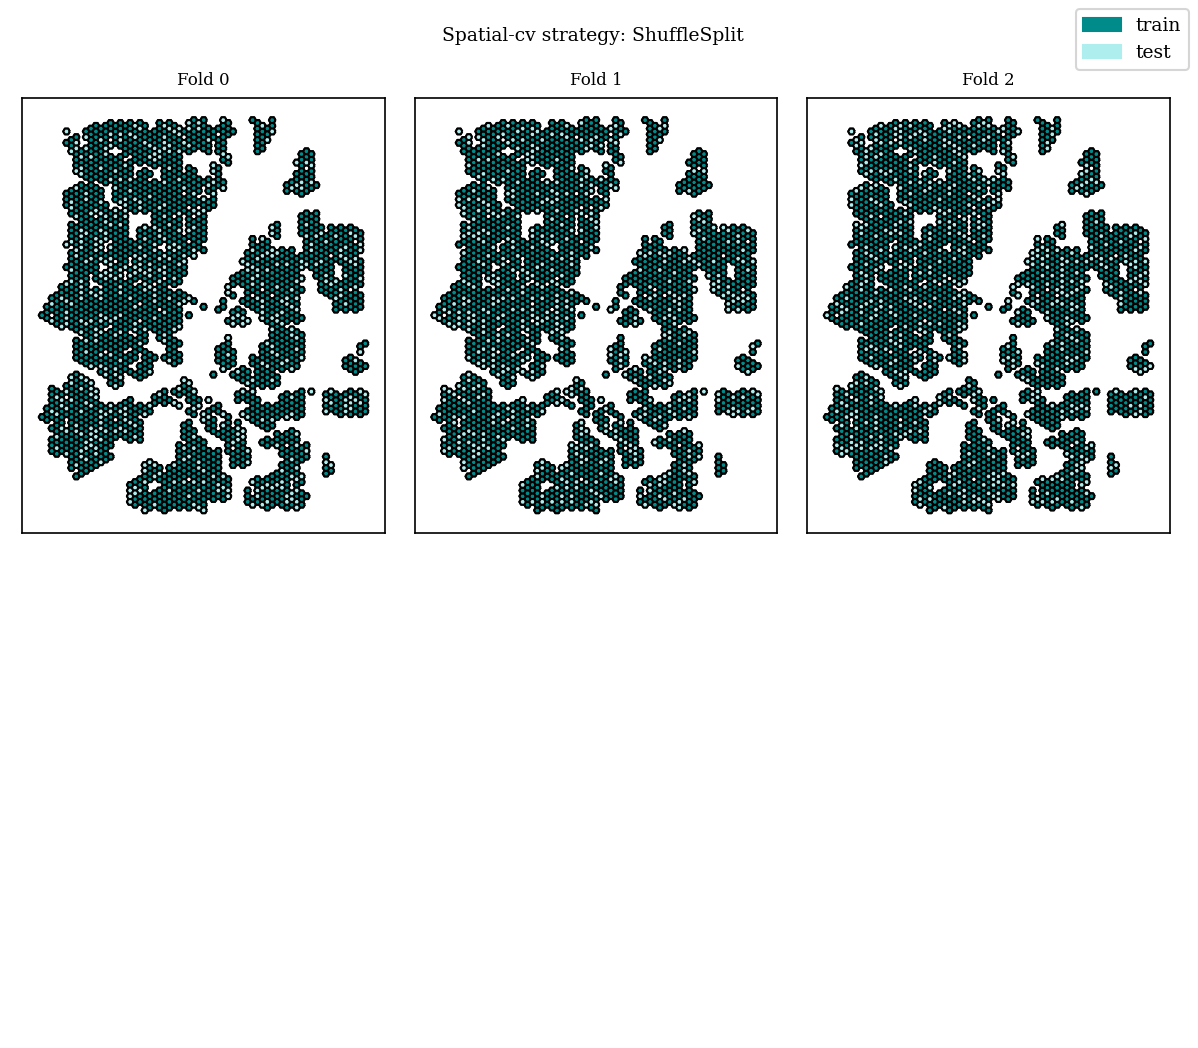

In [2]:
%time

data_dir = '../data'
data_raw_path = f'{data_dir}/raw/flint_sl_materials/'
save_dir = f'{data_dir}/processed'

# Build and save
Xdata_, Ydata_, pid_, train_idx_, test_idx_, _ = build_datasets(data_raw_path, save_dir=save_dir, plot_splits=True)

# Load from saved
# Xdata_, Ydata_, pid_, train_idx_, test_idx_, _ = load_datasets(save_dir)

In [5]:
train_idx.keys()

dict_keys(['ts_0.2'])

In [6]:
train_idx['ts_0.2'].keys()

dict_keys(['res_15'])

In [7]:
train_idx['ts_0.2']['res_15']

array([Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                       9,
                   ...
                   24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737,
                   24738],
                  dtype='int64', length=15399)                                   ,
       Int64Index([   48,    49,    50,    51,    52,    53,    54,    55,    56,
                      57,
                   ...
                   25054, 25055, 25056, 25057, 25058, 25059, 25060, 25061, 25062,
                   25063],
                  dtype='int64', length=18408)                                   ,
       Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                       9,
                   ...
                   25054, 25055, 25056, 25057, 25058, 25059, 25060, 25061, 25062,
                   25063],
                  dtype='int64', length=18290)                                   ],
      dtype=object)

In [8]:
test_idx['ts_0.2']['res_15']

array([Int64Index([  140,   141,   142,   143,   144,   145,   146,   147,   148,
                     149,
                   ...
                   25054, 25055, 25056, 25057, 25058, 25059, 25060, 25061, 25062,
                   25063],
                  dtype='int64', length=9665)                                    ,
       Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                       9,
                   ...
                   24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578, 24579,
                   24580],
                  dtype='int64', length=6656)                                    ,
       Int64Index([ 1046,  1047,  1048,  1049,  1050,  1051,  1052,  1053,  1054,
                    1055,
                   ...
                   24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737,
                   24738],
                  dtype='int64', length=6774)                                    ],
      dtype=object)

In [27]:
np.round(np.linspace(0,1, 8)[1:-1], 1)

array([0.1, 0.3, 0.4, 0.6, 0.7, 0.9])